In [9]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os

This function below is used to plot enmo, anglez, light, and other measurements 

In [10]:
def plot_series_data(df, plot_col=['non-wear_flag'], x_col='day_time'):
    
    colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'black', 'yellow', 'magenta', 'lime', 'teal', 'coral', 'lightblue', 'lightgreen', 'lavender', 'tan', 'salmon']
    
    number_of_plots = len(plot_col)
    plt.figure(figsize=(18, 3*number_of_plots))
    for i, y_col in enumerate(plot_col):
        plt.subplot(number_of_plots, 1, i+1)
        plt.scatter(df[x_col], df[y_col], label=y_col, color=colors[i], s=1)
        # plt.title(f'Plot for {y_col}')
        plt.ylabel(f'{y_col}')
        plt.xlabel(f'{x_col}')
        plt.fill_between(df[x_col], df[y_col].min(), df[y_col].max(),
                         where=(df['non-wear_flag'] == 0),
                         color='red', alpha=0.1, label='Non-wear device period')
        
        # plt.fill_between(df[x_col], df[y_col].min(), df[y_col].max(),
        #                  where=((df['time_of_day_hours'] < 7) | (df['time_of_day_hours'] > 22)),
        #                  color='cyan', alpha=0.13, label='Night time period')


    plt.tight_layout()
    plt.show()

Loading data

In [11]:
import random

list_of_participants = [id.split('=')[1] for id in os.listdir('./series_train.parquet')]
random.shuffle(list_of_participants)
# list_of_participants = list_of_participants[:10]
# print(list_of_participants)

In [12]:
# the whole train data
train = pd.read_csv('./train.csv')

In [13]:
participants_with_high_sii = train[train['sii'] == 3]['id'].tolist()
participants_with_high_sii = [p for p in participants_with_high_sii if p in list_of_participants]
print(participants_with_high_sii)

['35fa2ebf', '5e55e9fd', '7f44236f', '8148c785', '9eb283e4', 'a08ebf6e', 'aaefeff0', 'bc4eaf77', 'c308b134', 'df556fd2']


In [14]:
# one specific participant's time series data

participant_ids = ['54391716','0a418b57','6b6467f4','579e50bd','6282e693','8f21c613','2bbcfd43','7fa7ccc4','5f78f7b9','764d8b42','0417c91e','045a0a94', '04afb6f9', '04bb1a76', '055156e2', '0668373f', '08660d12', '09331bb8', '0d570d3e', '0ec403df', '10ad8c48', '113f5798', '137baaec', '144a9a79', '1957153d', '1aff6762', '1b2eea8f', '1b329556', '1eea8df2', '35fa2ebf', '5e55e9fd', '7f44236f', '8148c785', '9eb283e4', 'a08ebf6e', 'aaefeff0', 'bc4eaf77', 'c308b134', 'df556fd2']
participant_dfs = []

for participant_id in participant_ids:
    path = f'./series_train.parquet/id={participant_id}/part-0.parquet'
    series_train = pd.read_parquet(path) 

    # Create a continuous time scale in days by transforming the `time_of_day` column (which is in nanoseconds) to hours and then combining it with `relative_date_PCIAT``
    series_train['time_of_day_hours'] = (
        series_train['time_of_day'] / 1e9 / 3600 #nanoseconds to hours
    )
    series_train['day_time'] = series_train['relative_date_PCIAT'] + (
        series_train['time_of_day_hours'] / 24
    )
    series_train.drop(columns=['time_of_day'], inplace=True)
    participant_dfs.append(series_train)


# What does the time series look like?

### Here, I conduct preview of the data on 10 random participants. Let's see what the data tell us.

#### id =  54391716
- 12 years old
- sii = 0
- about 24 days of actigraphy data
- the measurements are taken pretty far from the PCIAT test --> maybe not relavant anymore
- non-wear-flag seems equally distributed between 0 and 1
- the participant mostly wear the device on day time from 7h to 22h (seems to perfectly fit this range), except the last 3 days when he wore the device all the time
- His enmo metric is kind of low for a 12yo kid. mostly under 2.
- battery go down gradually. The period of the last 3 days seen a drastical drop (out of energy). May be this is why the device tell it is being wore, also every other metric (X, Y, Z, enmo, anglez, light) burst out in this period (malfunction?)
- Fully in quarter 1
- All of the time measurements (realtive date, time of day, day time) are normal => this means the gaps among measurements are pretty equal

In [15]:
train[train['id'] == participant_ids[0]]

id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
1350  54391716                      Fall               12                1   

     CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  \
1350      Spring             60.0            Fall     17.554102   

      Physical-Height  Physical-Weight  ...  PCIAT-PCIAT_18  PCIAT-PCIAT_19  \
1350             58.0             84.0  ...             1.0             1.0   

      PCIAT-PCIAT_20  PCIAT-PCIAT_Total SDS-Season  SDS-SDS_Total_Raw  \
1350             1.0               30.0     Winter               40.0   

      SDS-SDS_Total_T  PreInt_EduHx-Season  \
1350             56.0                 Fall   

     PreInt_EduHx-computerinternet_hoursday  sii  
1350                                    2.0  0.0  

[1 rows x 82 columns]

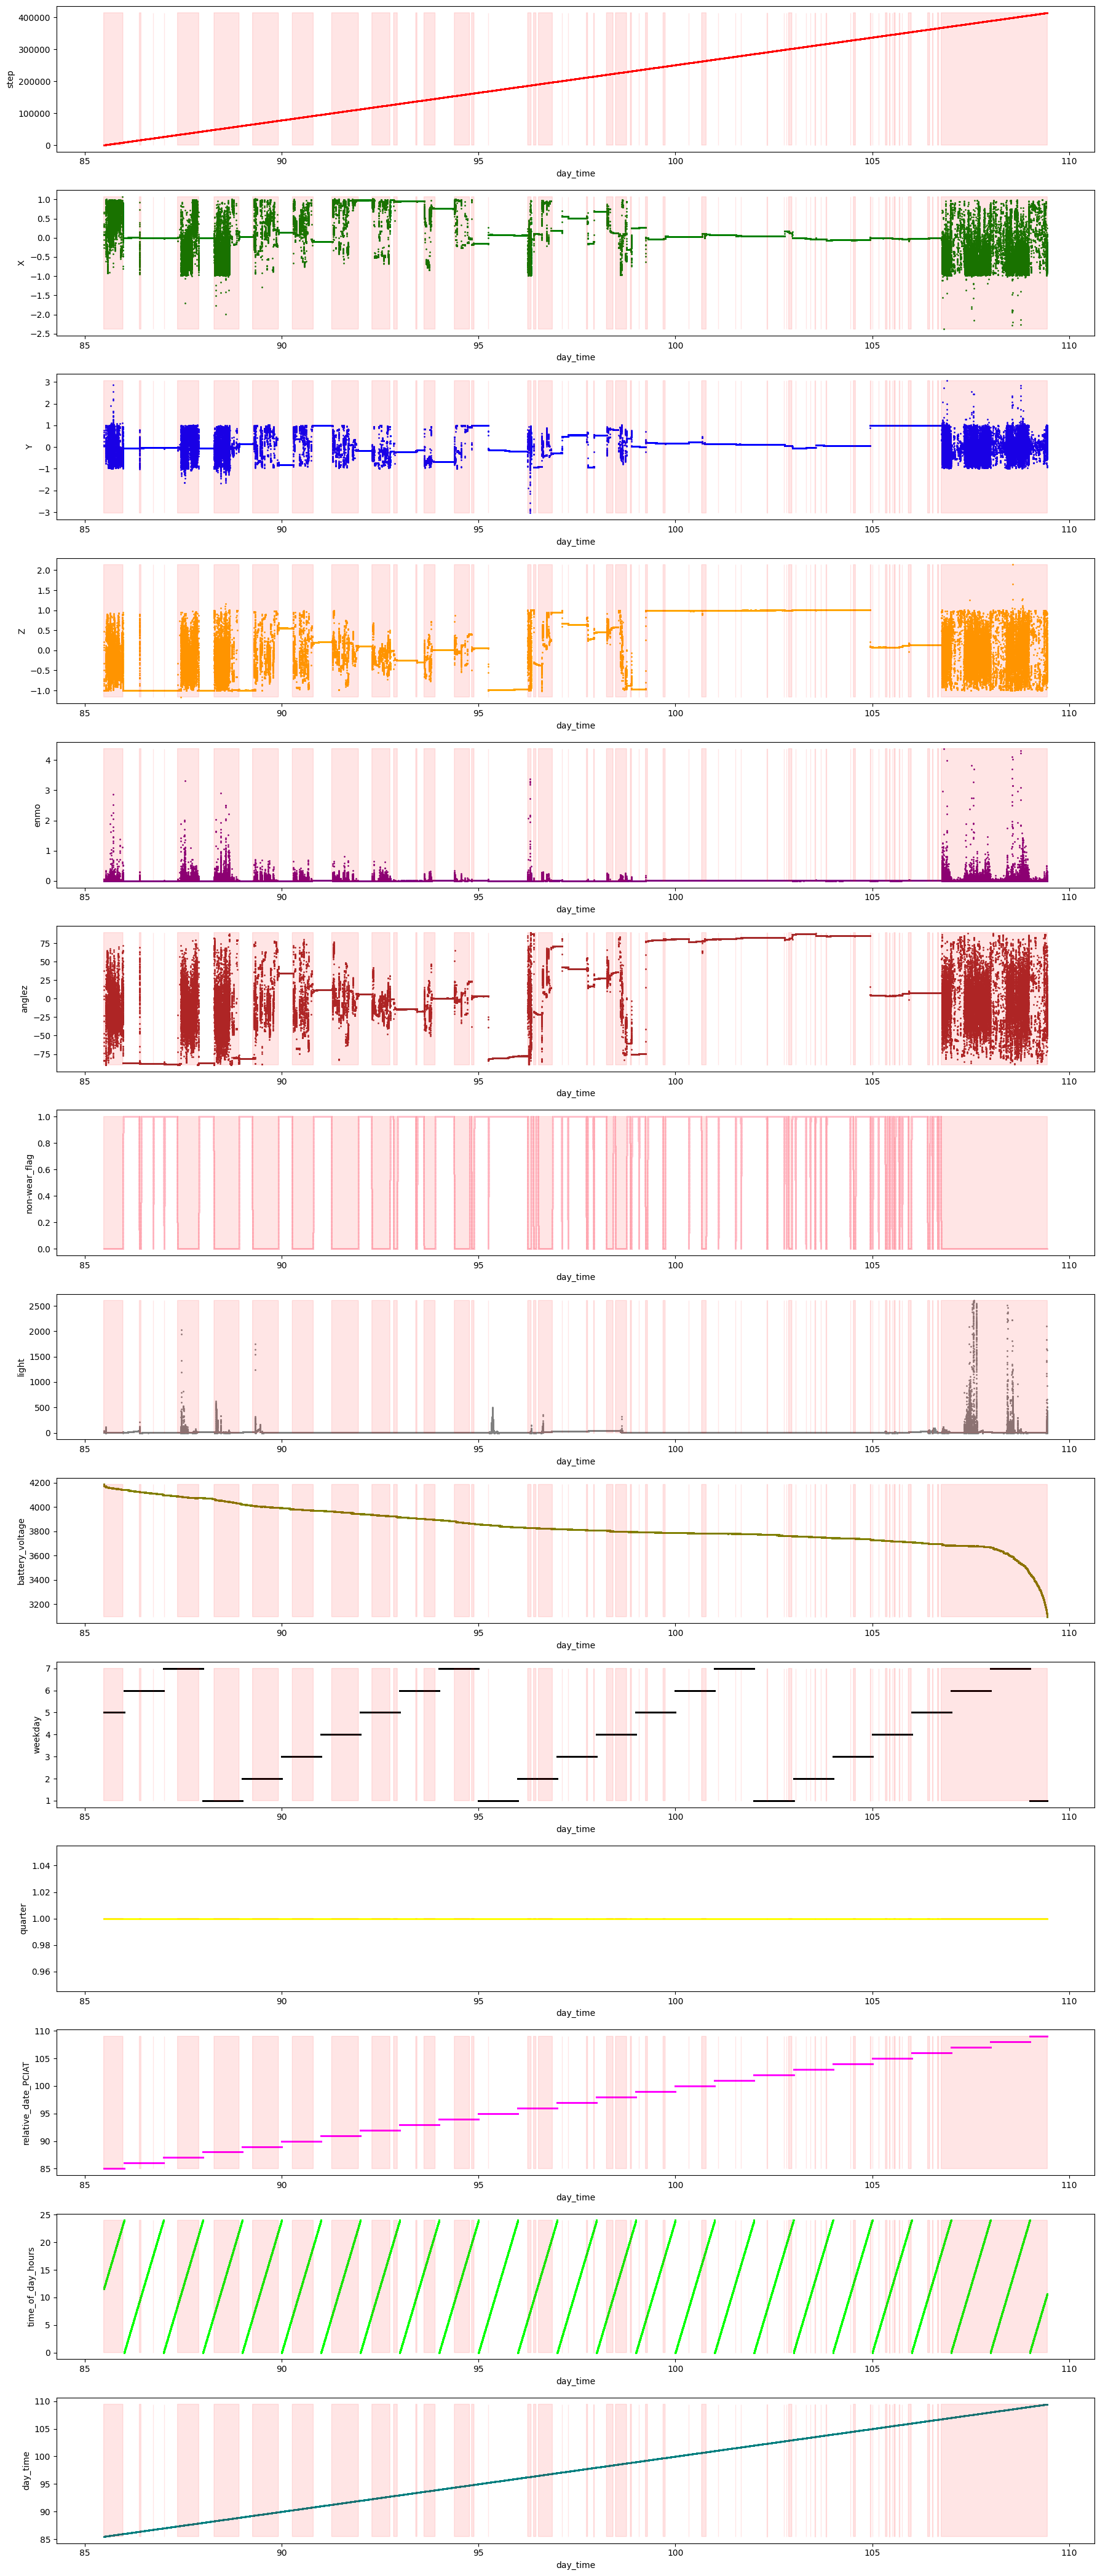

In [16]:
# train[train['id'] == participant_ids[0]]# Test the plot_series_data function

plot_series_data(participant_dfs[0], plot_col=series_train.columns, x_col='day_time')

#### id = 0a418b57
- 10 years old
- sii = 1
- about 31 days of actigraphy data
- there are 2 phases: before and after day 10
- the participant wear the device all the time
- the data is very even before day 10
- the kid is pretty active (0.5 < enmo < 3)
- anglez changes very frequently
--> the kid seem to be very active
- He disclose to the light ranging from office light to overcast day light pretty often
- in the reliable period (day_time <= 10), every metric is consistent.
- In the phase after day 10, the data seem abnomal, need to be cut. There are so much data missing. Steps' gaps are long

In [17]:
train[train['id'] == participant_ids[1]]

id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
178  0a418b57                    Spring               10                1   

    CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  \
178      Winter             80.0            Fall     16.629696   

     Physical-Height  Physical-Weight  ...  PCIAT-PCIAT_18  PCIAT-PCIAT_19  \
178             52.5             65.2  ...             3.0             3.0   

     PCIAT-PCIAT_20  PCIAT-PCIAT_Total SDS-Season  SDS-SDS_Total_Raw  \
178             2.0               45.0       Fall               33.0   

     SDS-SDS_Total_T  PreInt_EduHx-Season  \
178             47.0               Spring   

    PreInt_EduHx-computerinternet_hoursday  sii  
178                                    3.0  1.0  

[1 rows x 82 columns]

In [18]:
participant_dfs[1][participant_dfs[1]['day_time'] > 15]

step         X         Y         Z      enmo     anglez  \
209404  209404  0.142659  0.209491  0.963637  0.054528  75.405357   
209405  209405 -0.026943  0.042112  1.007569  0.010533  86.989250   
209406  209406 -0.039826 -0.137086  1.005097  0.027400  81.555771   
209407  209407  0.237207  0.053232  0.970820  0.021138  75.084412   
209408  209408  0.247870  0.110491  0.977509  0.023711  74.512848   
...        ...       ...       ...       ...       ...        ...   
213418  213418  0.391111  0.658119 -0.511350  0.060158 -35.455124   
213419  213419  0.551039  0.078267 -0.787324  0.094029 -52.621586   
213420  213420  0.667007 -0.126560 -0.751950  0.013104 -47.961002   
213421  213421  0.666465 -0.125810 -0.749048  0.010495 -47.928806   
213422  213422  0.666620 -0.125483 -0.747113  0.009121 -47.806187   

        non-wear_flag      light  battery_voltage  weekday  quarter  \
209404            0.0   4.775503      3800.000000        5        4   
209405            0.0   4.775578      3800.000000        5        4   
209406            0.0   4.775655      3800.000000        5        4   
209407            0.0   4.775731      3800.000000        5        4   
209408            0.0   4.775807      3800.000000        5        4   
...               ...        ...              ...      ...      ...   
213418            0.0  22.000000      3817.430664        1        4   
213419            0.0  22.000000      3817.430664        1        4   
213420            0.0  22.000000      3817.430664        1        4   
213421            0.0  22.000000      3817.430664        1        4   
213422            0.0  22.000000      3817.430664        1        4   

        relative_date_PCIAT  time_of_day_hours   day_time  
209404                 15.0           9.330556  15.388773  
209405                 15.0           9.331944  15.388831  
209406                 15.0           9.333333  15.388889  
209407                 15.0           9.334722  15.388947  
209408                 15.0           9.336111  15.389005  
...                     ...                ...        ...  
213418                 25.0          10.762500  25.448438  
213419                 25.0          10.763889  25.448495  
213420                 25.0          10.837500  25.451563  
213421                 25.0          10.838889  25.451620  
213422                 25.0          10.840278  25.451678  

[4019 rows x 14 columns]

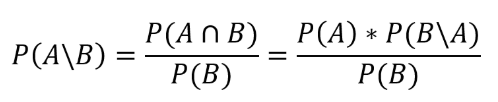

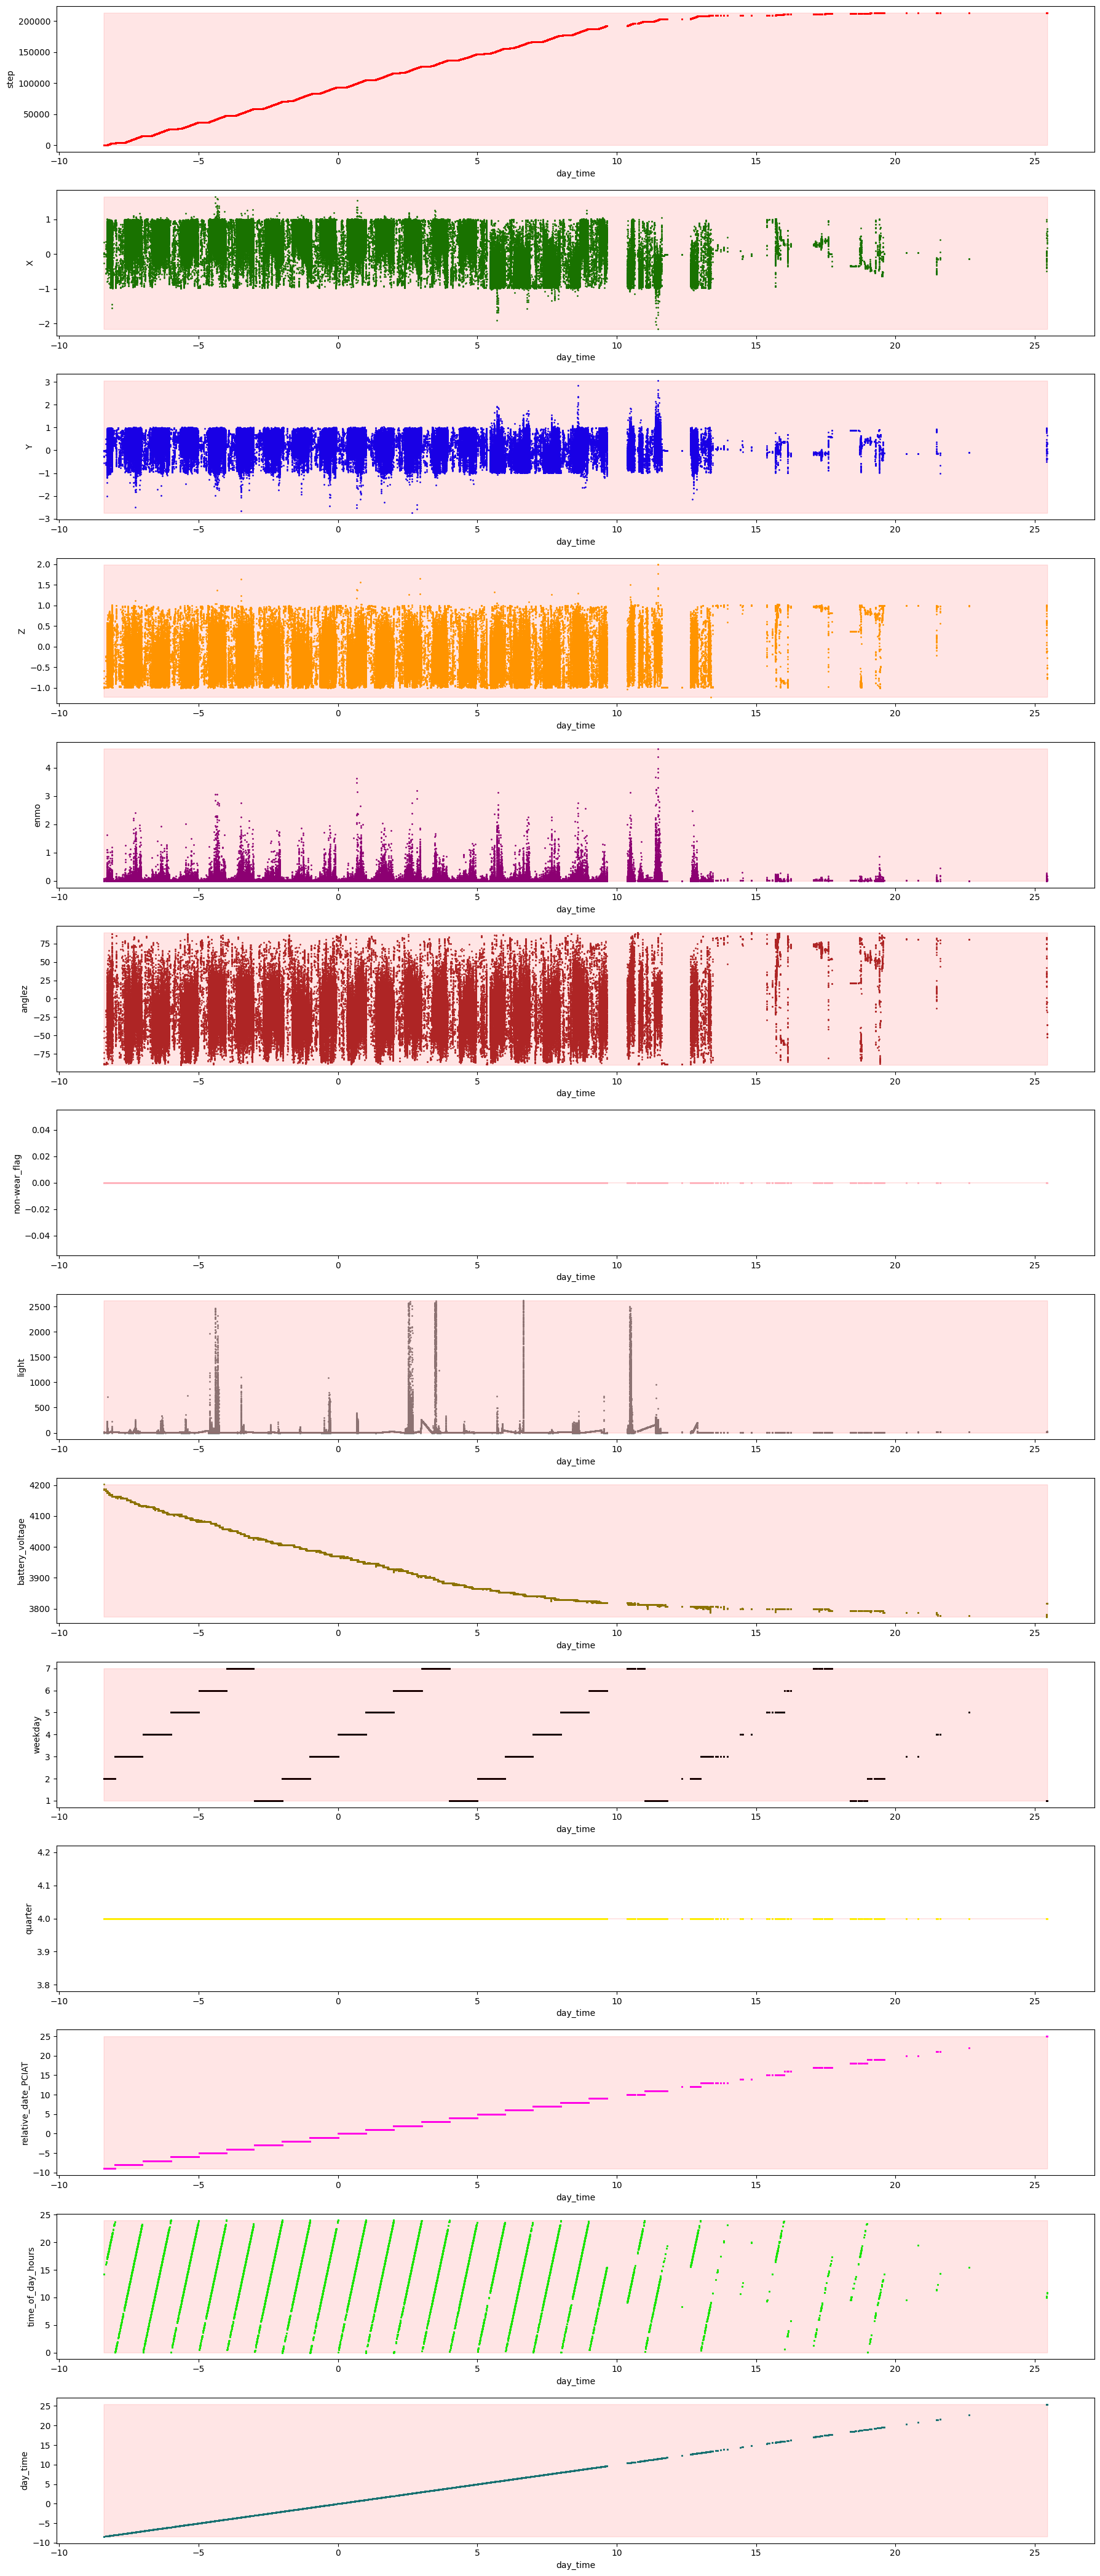

In [19]:
plot_series_data(participant_dfs[1], plot_col=series_train.columns, x_col='day_time')

#### id = 6b6467f4
- 16 years old
- sii = 2
- This one only have data for half of a day
- of course wear the device all the time
- the enmo is very low in the time of measurements
- he stays up late (to 24h00)
- anglez change very frequently with wide range of angles
- he's mostly in room light and dark

In [20]:
train[train['id'] == participant_ids[2]]

id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
1703  6b6467f4                      Fall               16                1   

     CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  \
1703      Spring             60.0            Fall     32.636489   

      Physical-Height  Physical-Weight  ...  PCIAT-PCIAT_18  PCIAT-PCIAT_19  \
1703             67.0            208.4  ...             4.0             2.0   

      PCIAT-PCIAT_20  PCIAT-PCIAT_Total SDS-Season  SDS-SDS_Total_Raw  \
1703             5.0               78.0        NaN                NaN   

      SDS-SDS_Total_T  PreInt_EduHx-Season  \
1703              NaN                 Fall   

     PreInt_EduHx-computerinternet_hoursday  sii  
1703                                    2.0  2.0  

[1 rows x 82 columns]

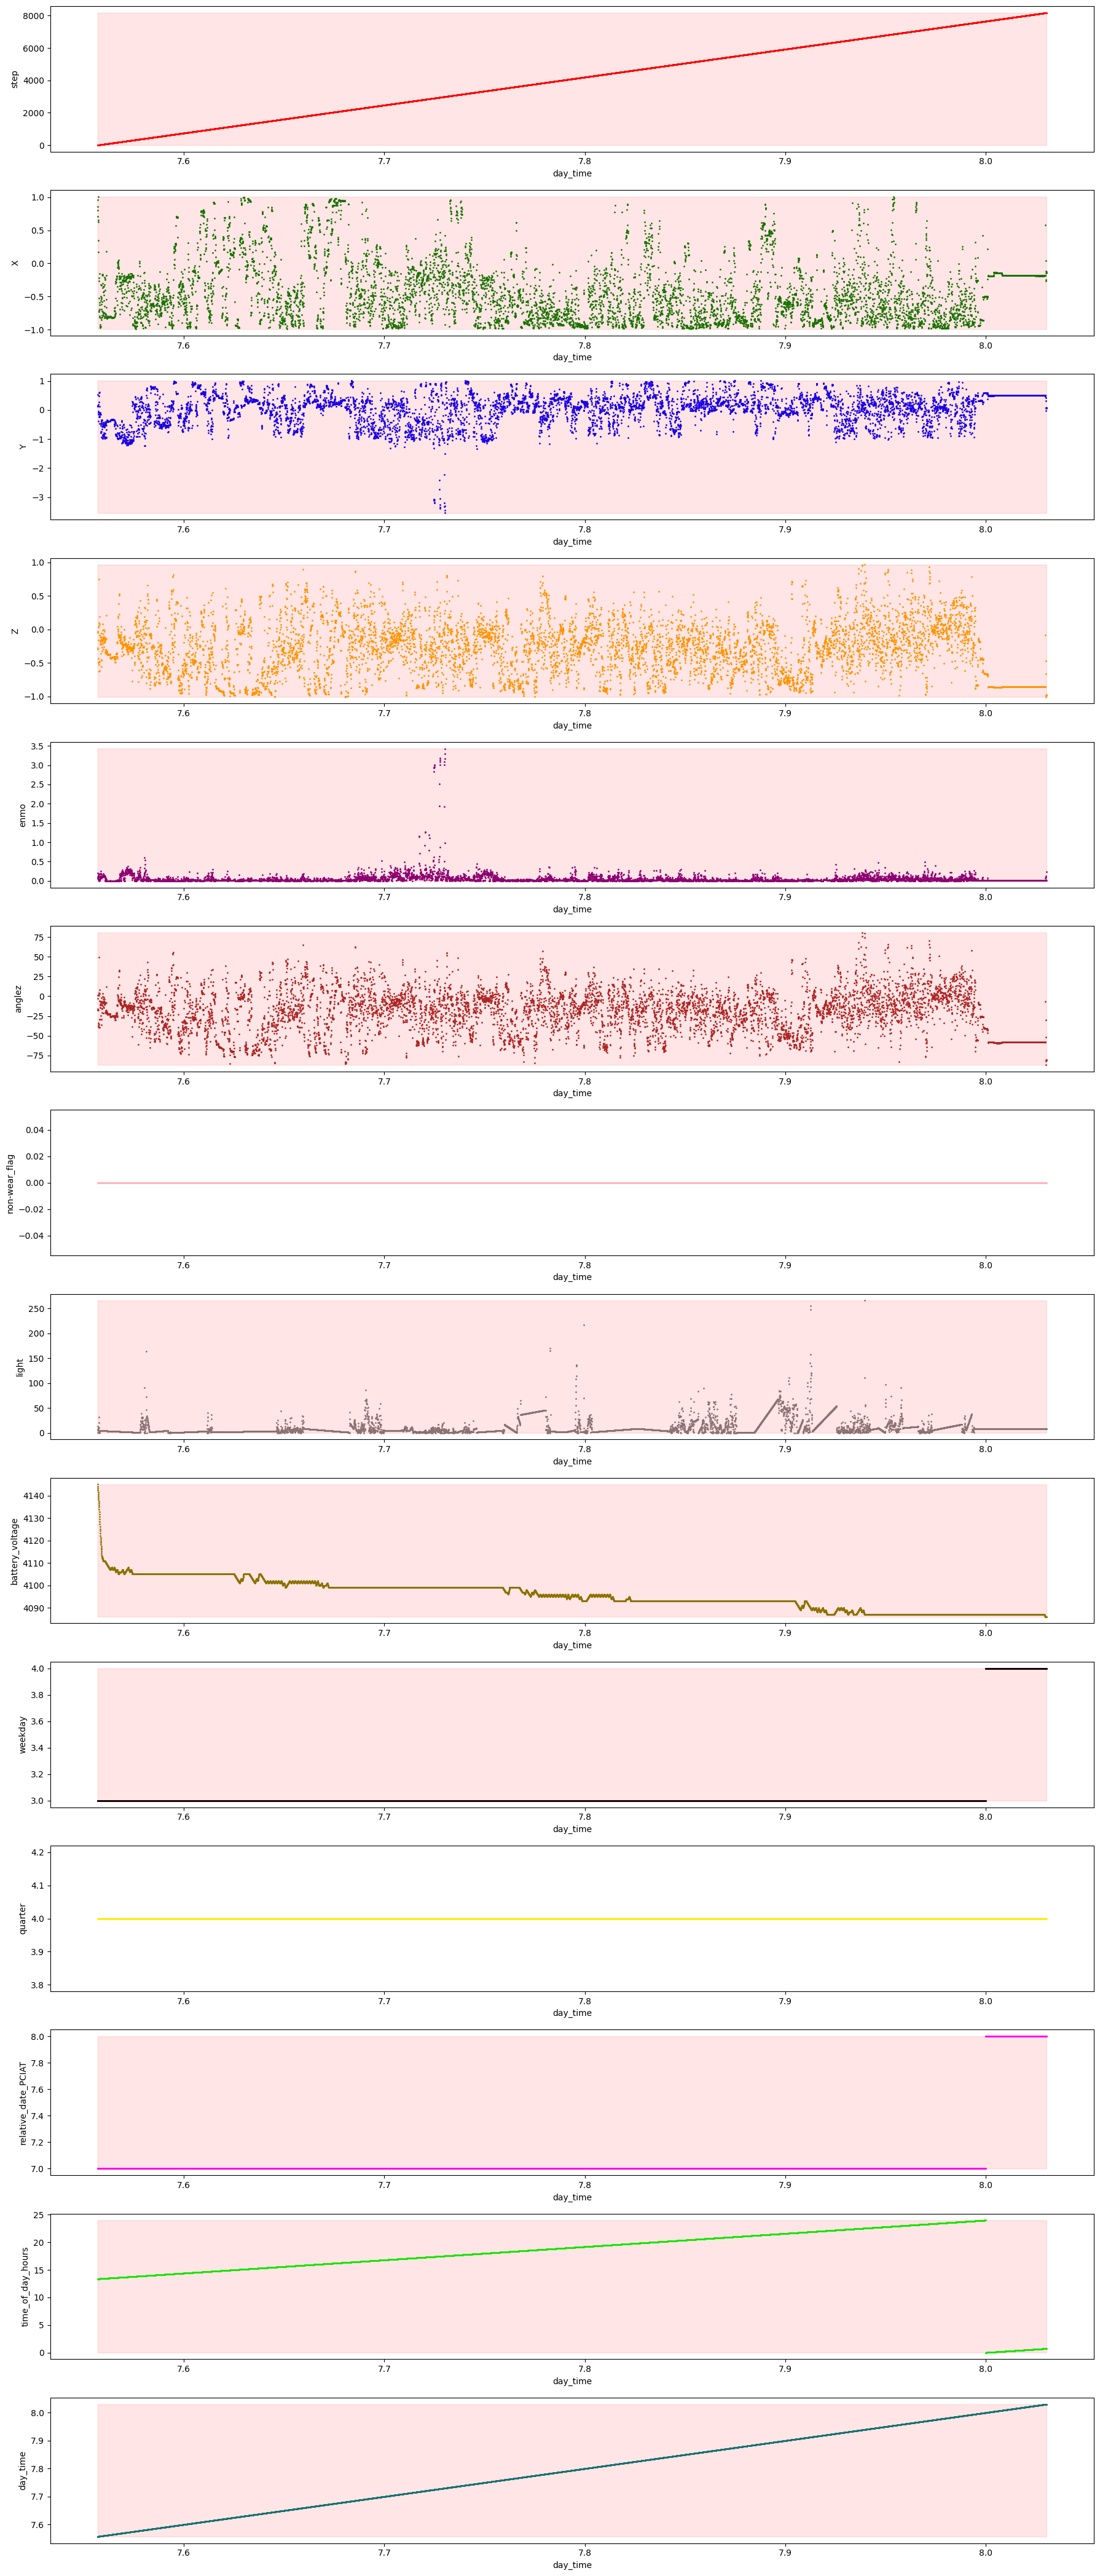

In [21]:
plot_series_data(participant_dfs[2], plot_col=series_train.columns, x_col='day_time')

#### id = 579e50bd
- 12 years old
- sii = 0
- about 22 days of actigraphy data
- only wear the device in day time. However, about half of the time (day time), he take it off
- enmo ranging mostly from 0 to 1.5. max is 3
- wide range of anglez. moving up and down pretty frequently
- usually in outdoor
- the measure ment is consistant. no period of big gaps
- mostly in quarter 1. 
- pretty far from the PCIAT test. may not be very relavant anymore


In [22]:
train[train['id'] == participant_ids[3]]

id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
1405  579e50bd                      Fall               12                1   

     CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  \
1405      Spring             85.0          Winter     17.924813   

      Physical-Height  Physical-Weight  ...  PCIAT-PCIAT_18  PCIAT-PCIAT_19  \
1405             62.5             99.6  ...             1.0             1.0   

      PCIAT-PCIAT_20  PCIAT-PCIAT_Total SDS-Season  SDS-SDS_Total_Raw  \
1405             1.0               18.0     Winter               29.0   

      SDS-SDS_Total_T  PreInt_EduHx-Season  \
1405             42.0                 Fall   

     PreInt_EduHx-computerinternet_hoursday  sii  
1405                                    1.0  0.0  

[1 rows x 82 columns]

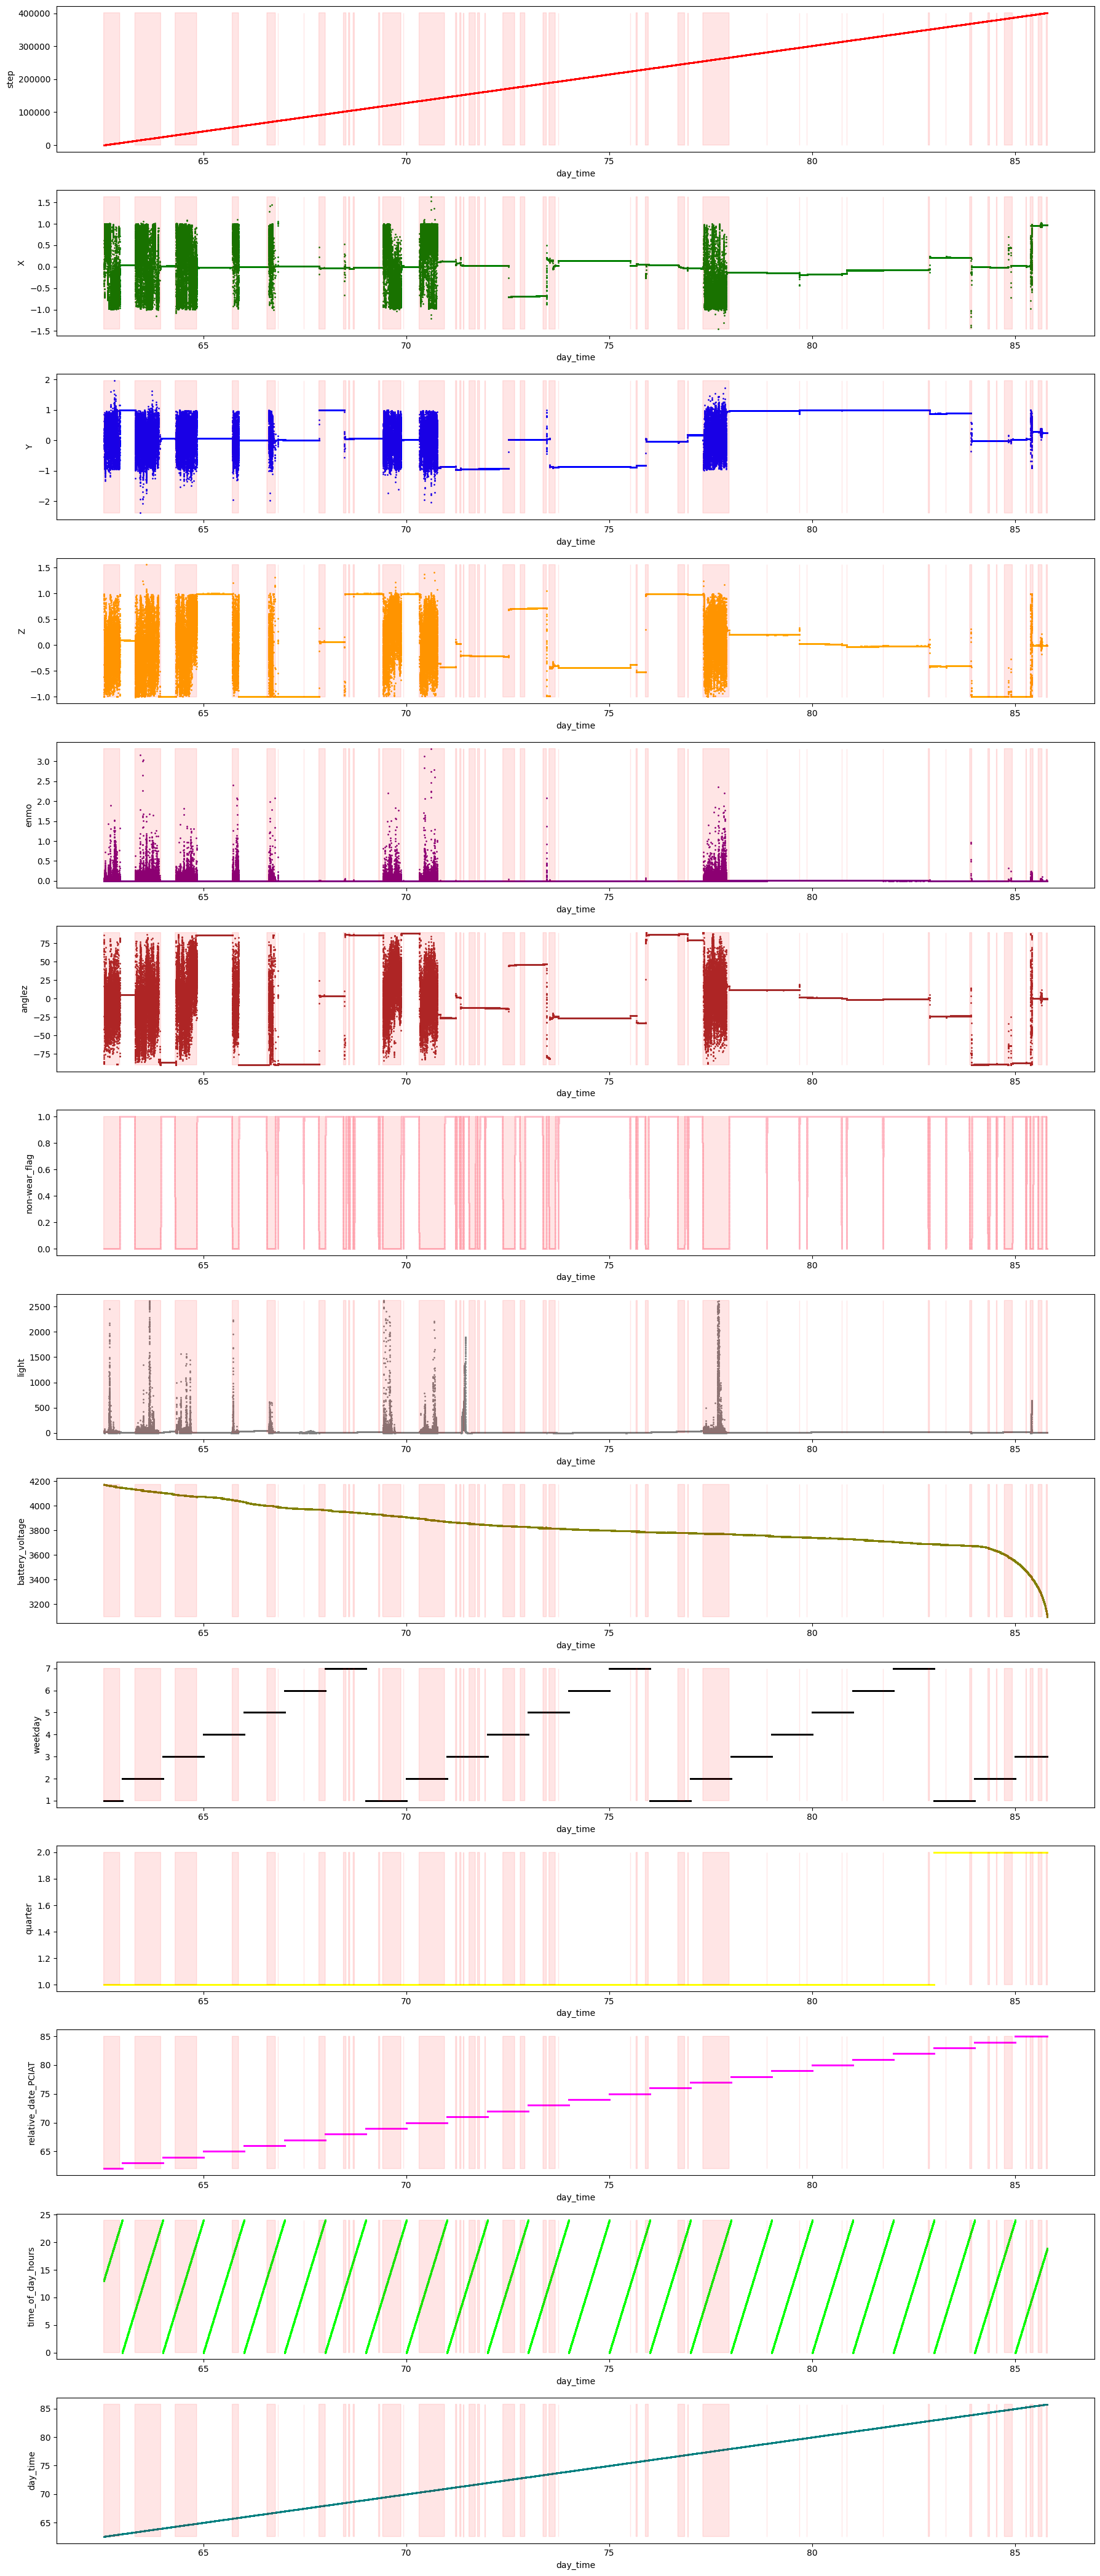

In [23]:
plot_series_data(participant_dfs[3], plot_col=series_train.columns, x_col='day_time')

#### id = 6282e693
- 5 years old (so young)
- sii = 0 (sure)
- data scatter for about 72 days. but only the days before day 19 seem consistent. after day 19, so many measurements are missing (big gaps)
- he wear the device all the time
- the device may be turned off for a while in day 9
- the boy seem active (enmo ranging from 0.4 to 1.5, anglez has a wide range and change frequently)
- exposed to day light usually
- fully in quarter 4

In [24]:
train[train['id'] == participant_ids[4]]

id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
1566  6282e693                    Summer                5                0   

     CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  \
1566      Winter             61.0          Summer     13.515964   

      Physical-Height  Physical-Weight  ...  PCIAT-PCIAT_18  PCIAT-PCIAT_19  \
1566            43.75             36.8  ...             0.0             0.0   

      PCIAT-PCIAT_20  PCIAT-PCIAT_Total SDS-Season  SDS-SDS_Total_Raw  \
1566             0.0                3.0        NaN                NaN   

      SDS-SDS_Total_T  PreInt_EduHx-Season  \
1566              NaN               Summer   

     PreInt_EduHx-computerinternet_hoursday  sii  
1566                                    0.0  0.0  

[1 rows x 82 columns]

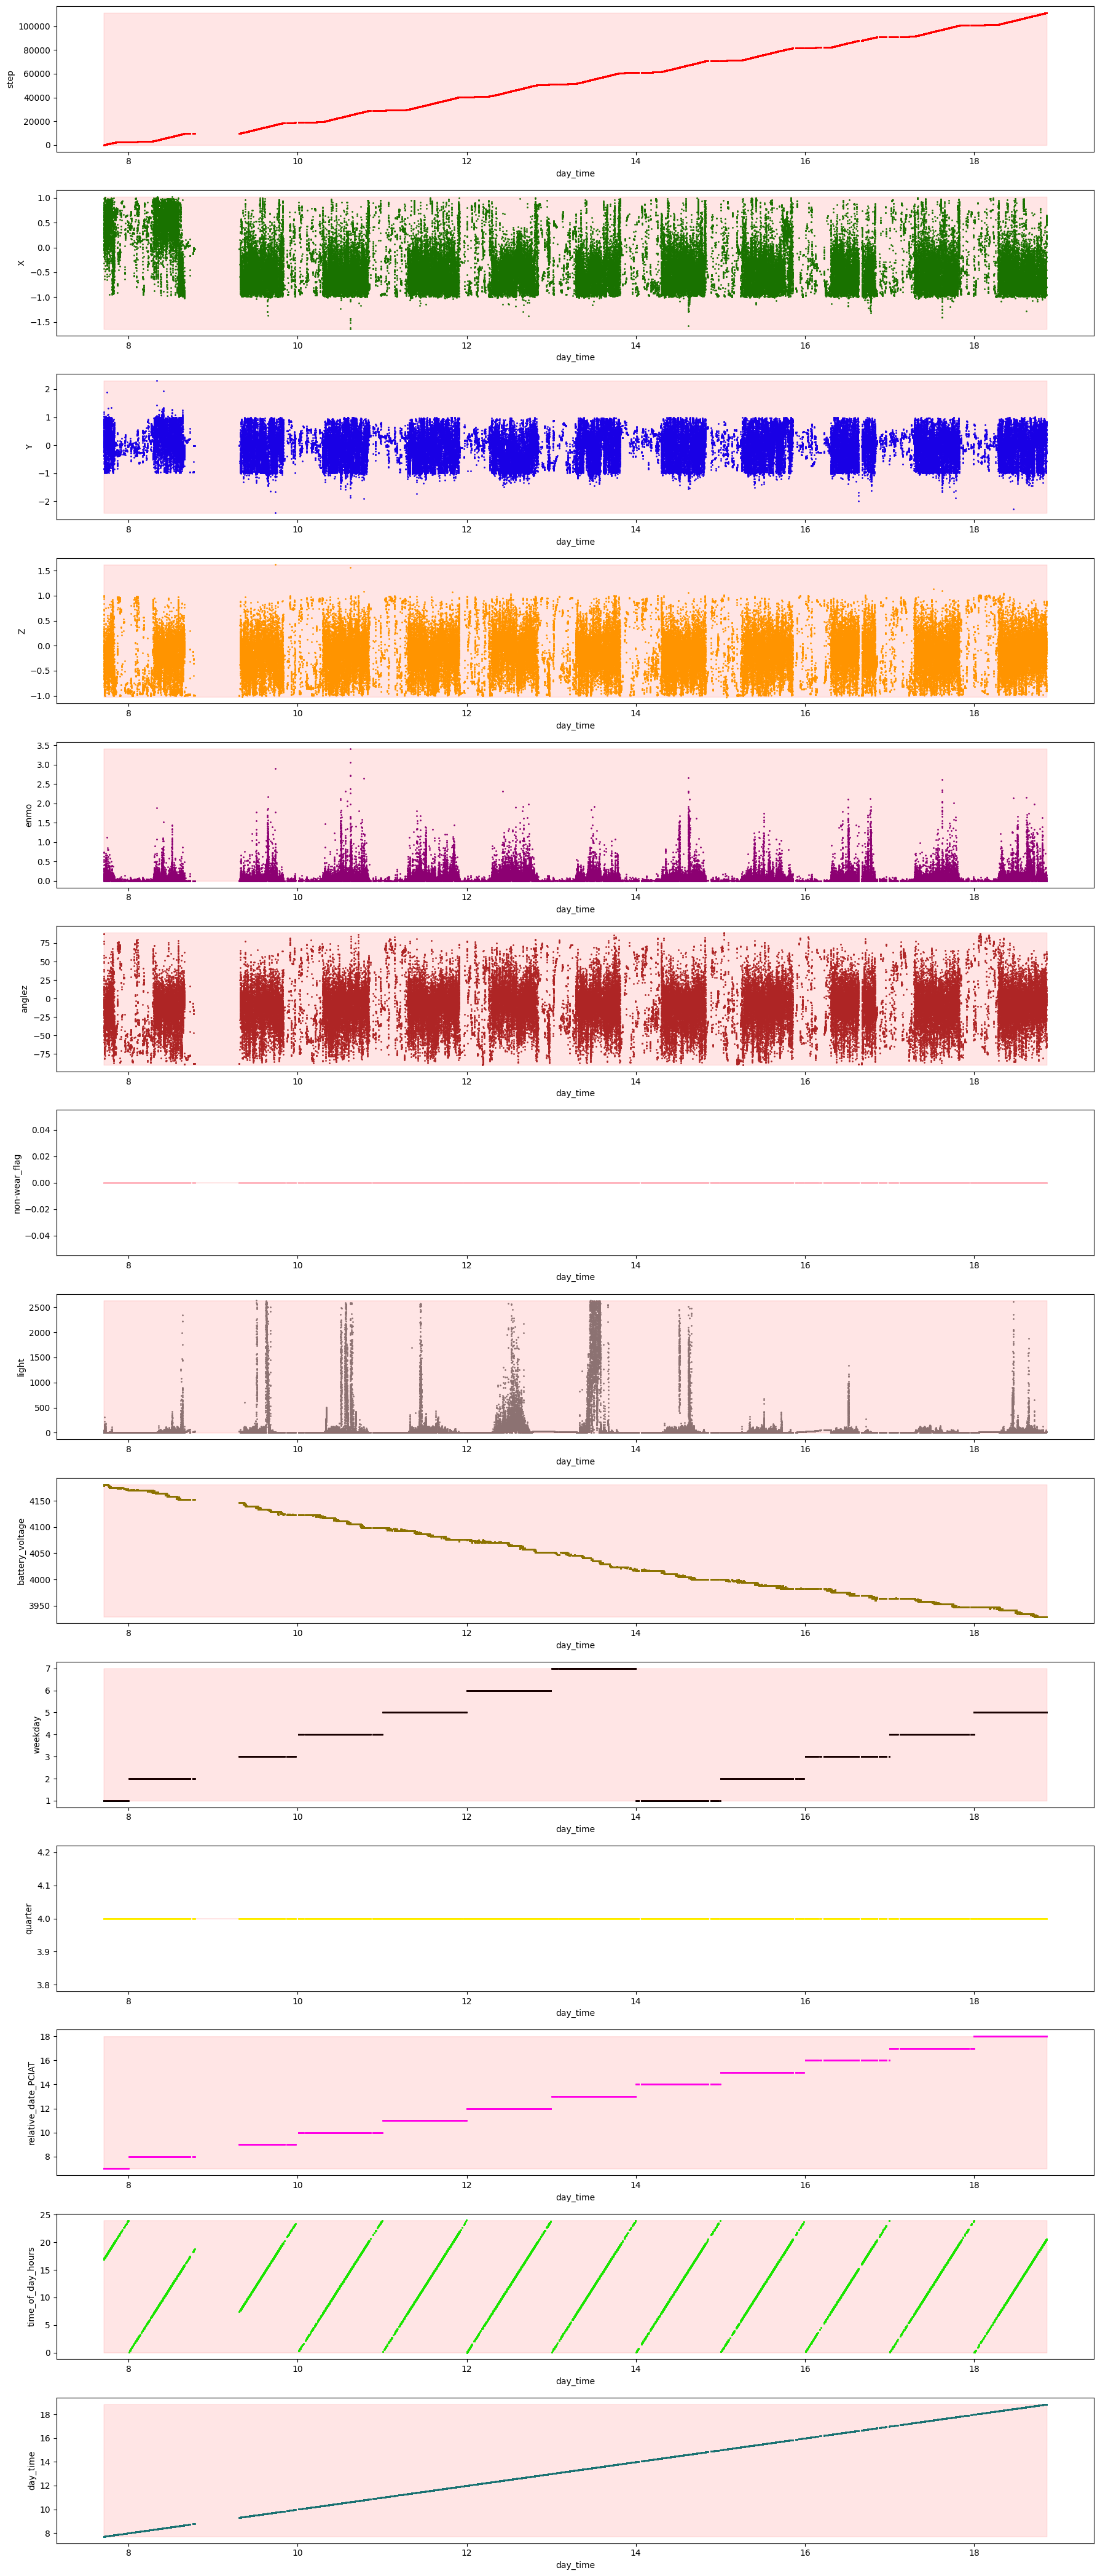

In [25]:
plot_series_data(participant_dfs[4][participant_dfs[4]['day_time'] < 19], plot_col=series_train.columns, x_col='day_time')

#### id = 8f21c613
- 13 years old
- sii = 1
- data collected through about 33 days
- the boy always wear the device
- he seems to stay up late and get up late very often. sometime stays up 3-4p.m
- he is pretty active (wide range of enmo and anglez)
- the boy seems to be active (medium range of enmo and wide range of anglez)
- he often exposes to the outdoor light
- fully quarter 2

In [26]:
train[train['id'] == participant_ids[5]]

id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
2258  8f21c613                    Winter               13                0   

     CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  \
2258      Spring             68.0          Spring     18.608824   

      Physical-Height  Physical-Weight  ...  PCIAT-PCIAT_18  PCIAT-PCIAT_19  \
2258             68.0            122.4  ...             2.0             1.0   

      PCIAT-PCIAT_20  PCIAT-PCIAT_Total SDS-Season  SDS-SDS_Total_Raw  \
2258             1.0               32.0     Spring               37.0   

      SDS-SDS_Total_T  PreInt_EduHx-Season  \
2258             53.0               Winter   

     PreInt_EduHx-computerinternet_hoursday  sii  
2258                                    0.0  1.0  

[1 rows x 82 columns]

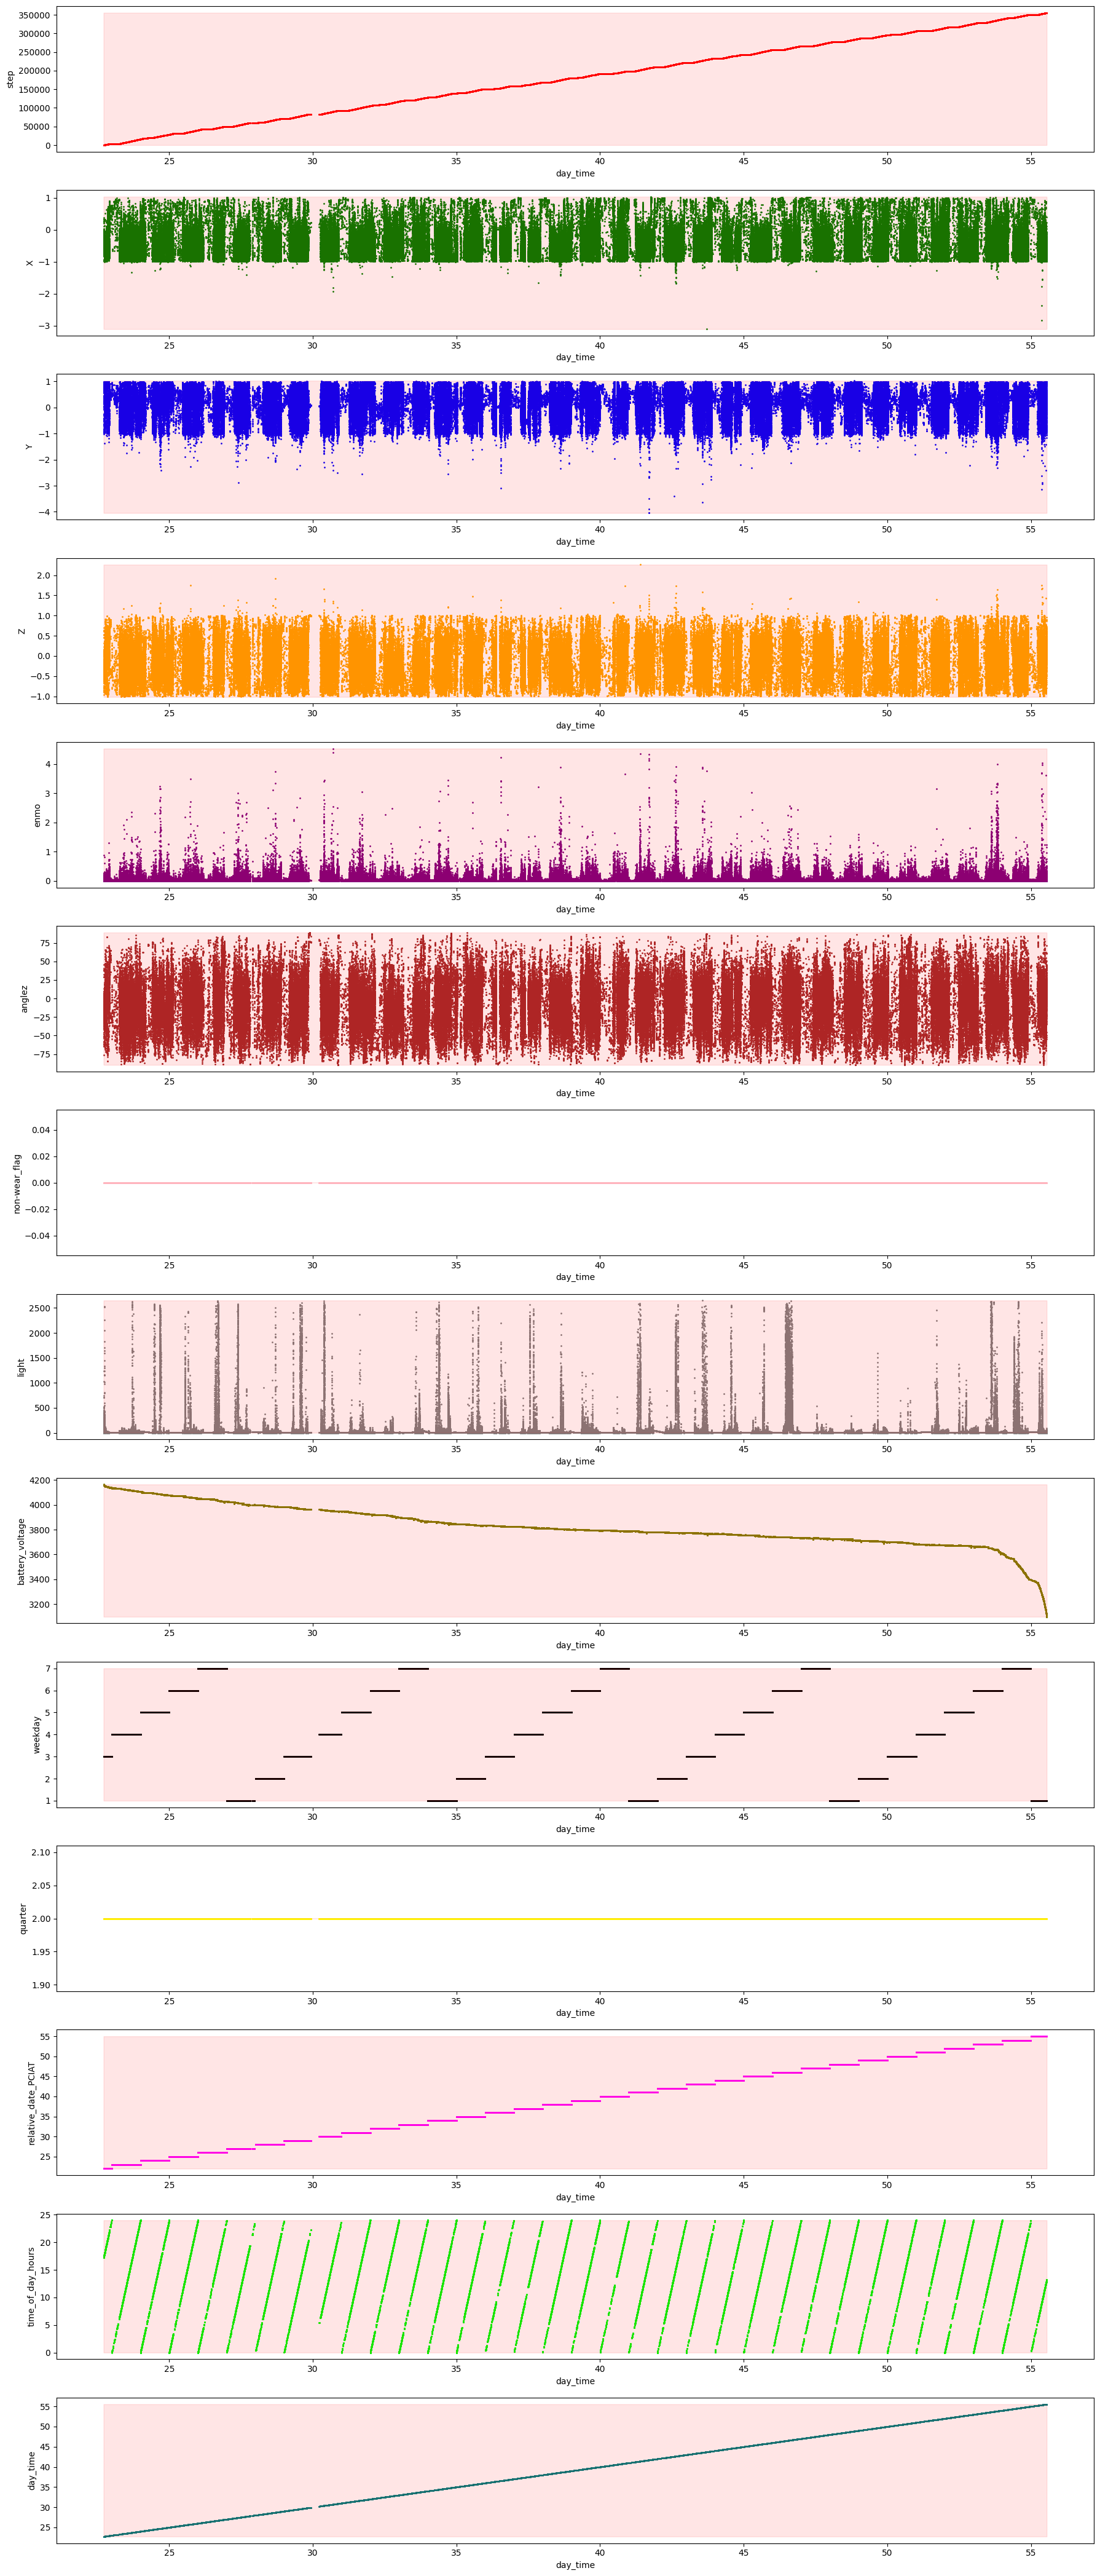

In [27]:
plot_series_data(participant_dfs[5], plot_col=series_train.columns, x_col='day_time')

#### id = 2bbcfd43
- 10 years old
- sii = 0
- data collected for about 22 days
- the data seem to be very consistent (no big time gaps)
- the participants wear the device most of the time
- user seems to have good bedtime (7h - 22h)
- the enmo is just like the others above, ranging from 0 to 3
- anglez have a wide range
- the girl usually expose the outdoor light 
- the PCIAT was took not too long ago

In [28]:
train[train['id'] == participant_ids[6]]

id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
726  2bbcfd43                    Winter               10                1   

    CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  \
726      Spring             55.0          Winter     15.570579   

     Physical-Height  Physical-Weight  ...  PCIAT-PCIAT_18  PCIAT-PCIAT_19  \
726             55.0             67.0  ...             1.0             1.0   

     PCIAT-PCIAT_20  PCIAT-PCIAT_Total SDS-Season  SDS-SDS_Total_Raw  \
726             1.0                9.0     Winter               26.0   

     SDS-SDS_Total_T  PreInt_EduHx-Season  \
726             38.0               Winter   

    PreInt_EduHx-computerinternet_hoursday  sii  
726                                    0.0  0.0  

[1 rows x 82 columns]

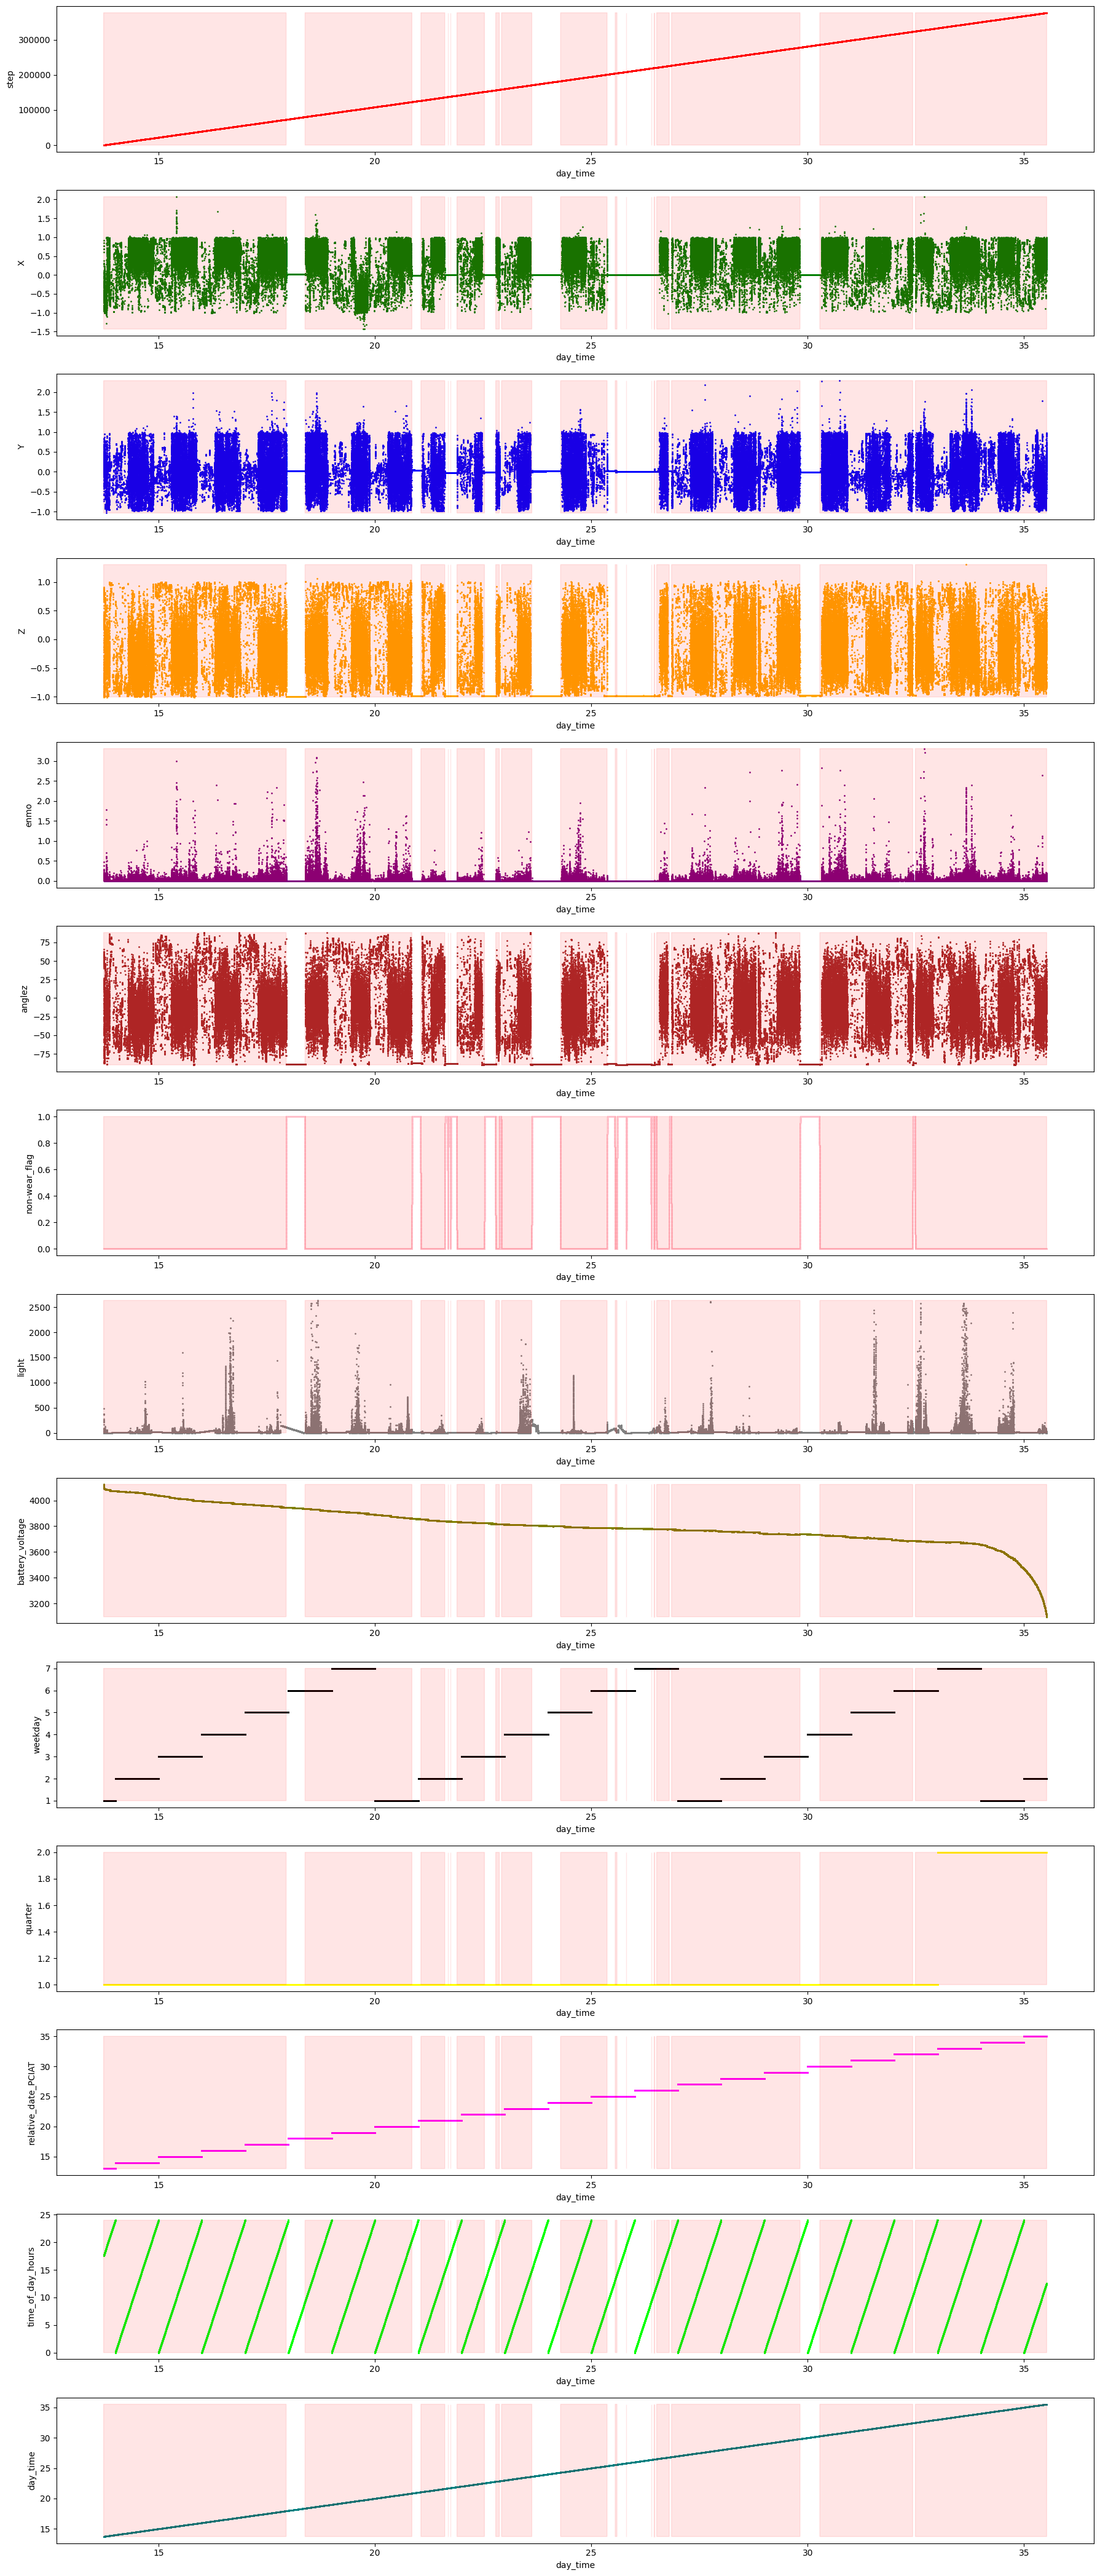

In [29]:
plot_series_data(participant_dfs[6], plot_col=series_train.columns, x_col='day_time')

#### id = 7fa7ccc4
- 9 years old
- sii = 0
- data is measured for about 24 days
- data very consistent (no big time gaps)
- user wear the device all the time (only a few day she took it off at night time)
- bed time is okay, not stay up late. only a few time she stay up late
- her exposure to sun light is most of the time
- she is very active (compared to the others above)

In [30]:
train[train['id'] == participant_ids[7]]

id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
2008  7fa7ccc4                    Winter                9                1   

     CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  \
2008      Spring             45.0          Winter     16.117172   

      Physical-Height  Physical-Weight  ...  PCIAT-PCIAT_18  PCIAT-PCIAT_19  \
2008             57.5             75.8  ...             2.0             0.0   

      PCIAT-PCIAT_20  PCIAT-PCIAT_Total SDS-Season  SDS-SDS_Total_Raw  \
2008             0.0               15.0     Spring               31.0   

      SDS-SDS_Total_T  PreInt_EduHx-Season  \
2008             45.0               Winter   

     PreInt_EduHx-computerinternet_hoursday  sii  
2008                                    0.0  0.0  

[1 rows x 82 columns]

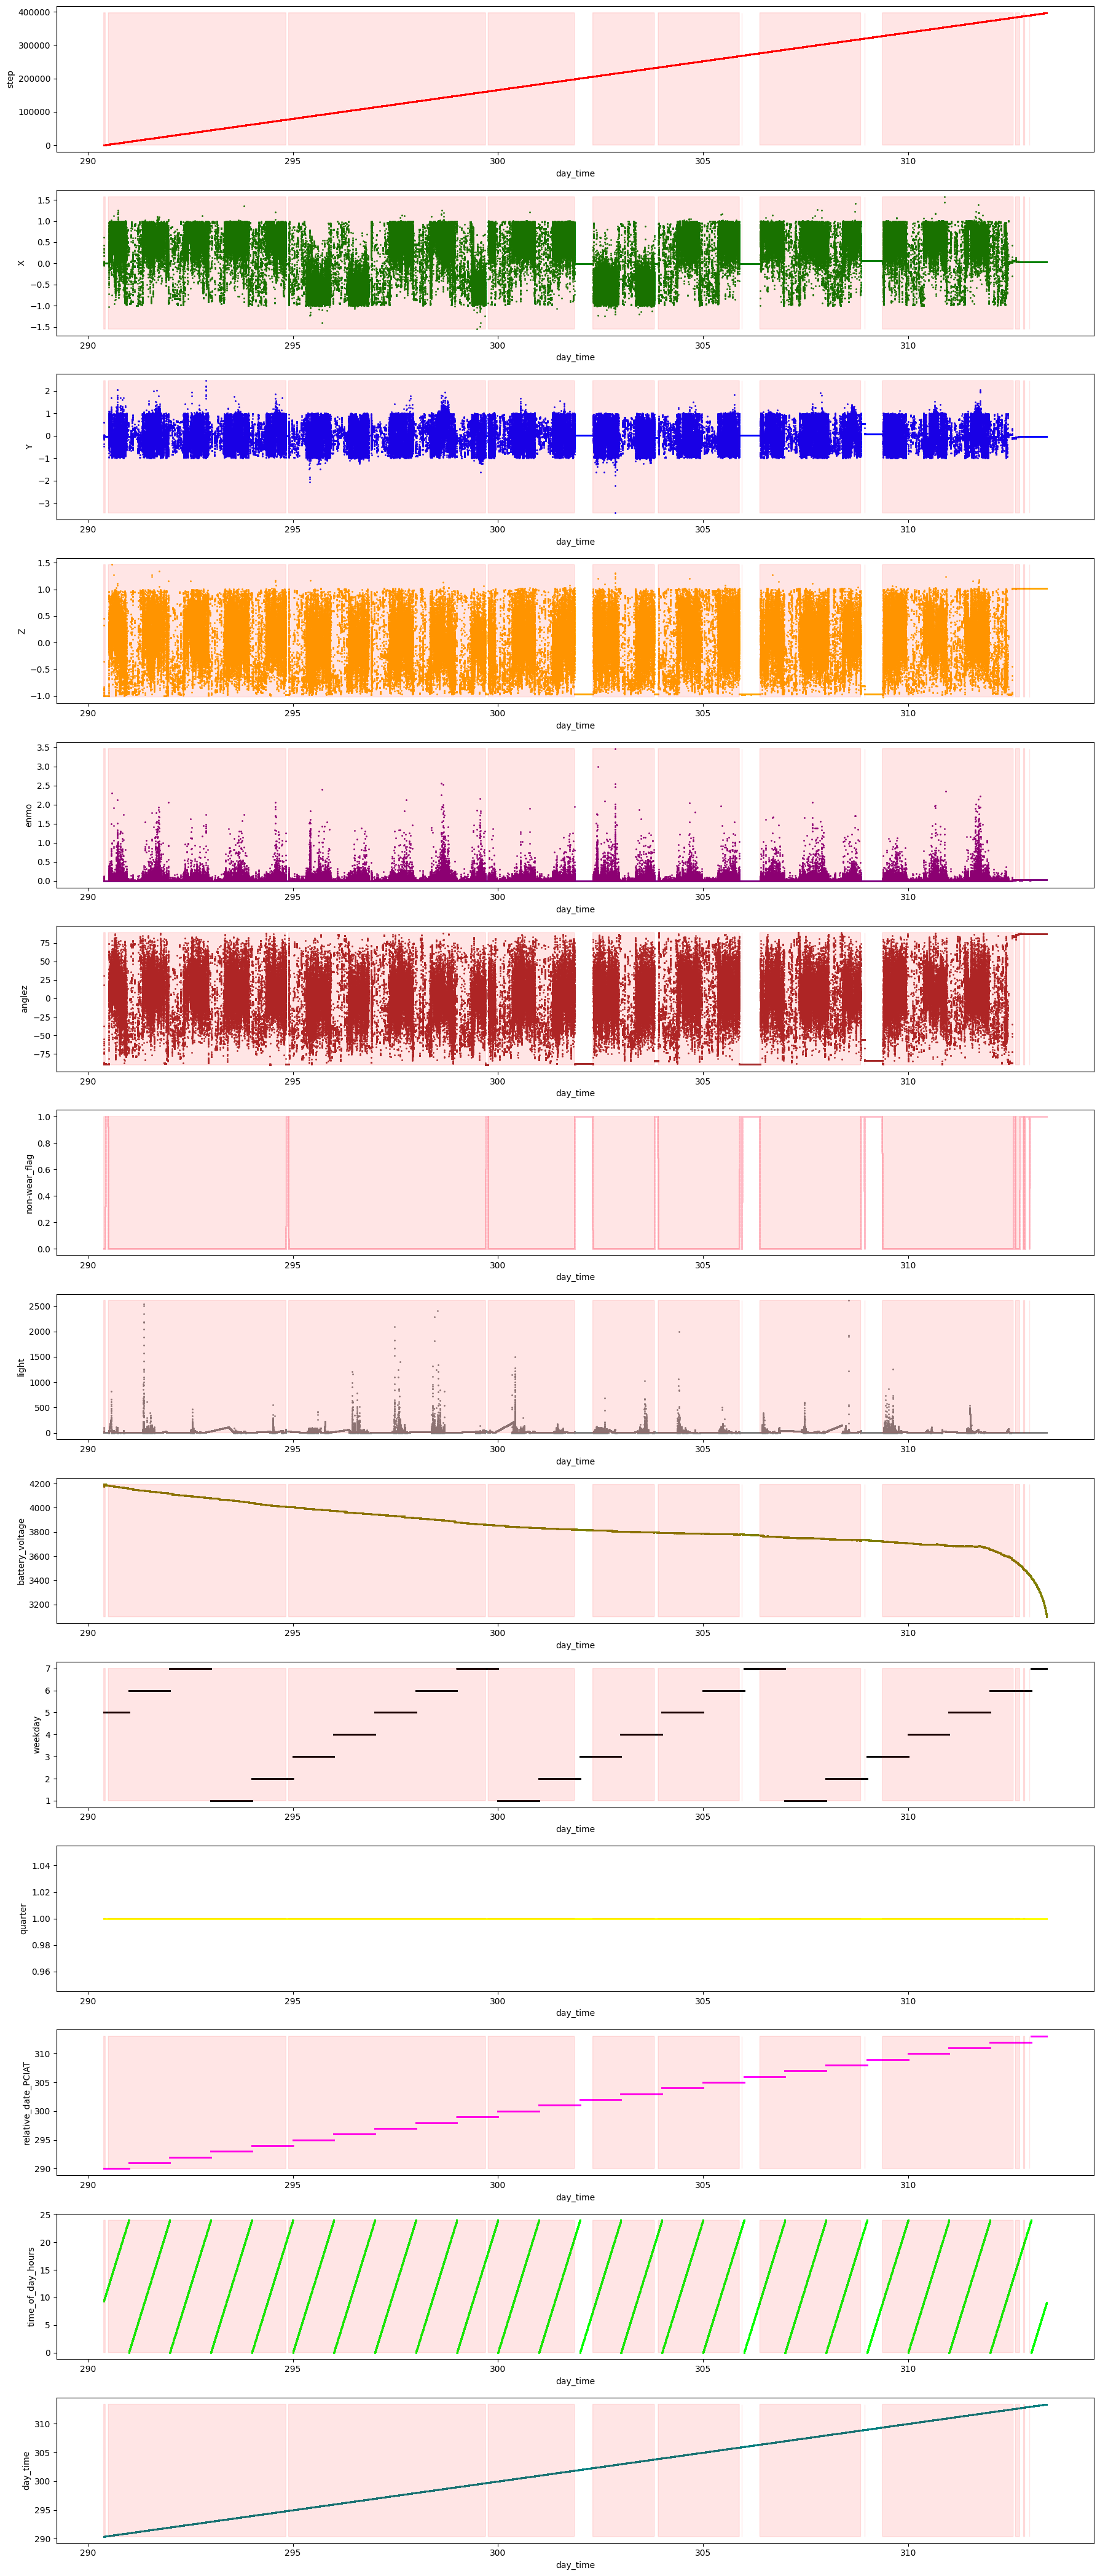

In [31]:
plot_series_data(participant_dfs[7], plot_col=series_train.columns, x_col='day_time')

#### id = 5f78f7b9
- 9 years old
- sii = 0
- data is collected in about 5,5 days
- the data looks consistent (no big time gaps)
- the period kind of short but still close to the PCIAT test
- this one's light data is kind of fake (a linear trend toward the time period of over 3 days)
- enmo very low (less than 0.4)
- anglez pretty high
- the X and Y accelemeter seem very aligned to each other --> synthetic? (another trait of fake data)
- this one's time is too short and he also doesn't wear the device much, and this data also looks fake --> this kind of data should be excluded


In [32]:
train[train['id'] == participant_ids[8]]

id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
1527  5f78f7b9                    Spring                9                1   

     CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  \
1527      Winter             85.0            Fall     15.672852   

      Physical-Height  Physical-Weight  ...  PCIAT-PCIAT_18  PCIAT-PCIAT_19  \
1527            56.75             71.8  ...             1.0             1.0   

      PCIAT-PCIAT_20  PCIAT-PCIAT_Total SDS-Season  SDS-SDS_Total_Raw  \
1527             0.0               16.0       Fall               38.0   

      SDS-SDS_Total_T  PreInt_EduHx-Season  \
1527             54.0               Spring   

     PreInt_EduHx-computerinternet_hoursday  sii  
1527                                    0.0  0.0  

[1 rows x 82 columns]

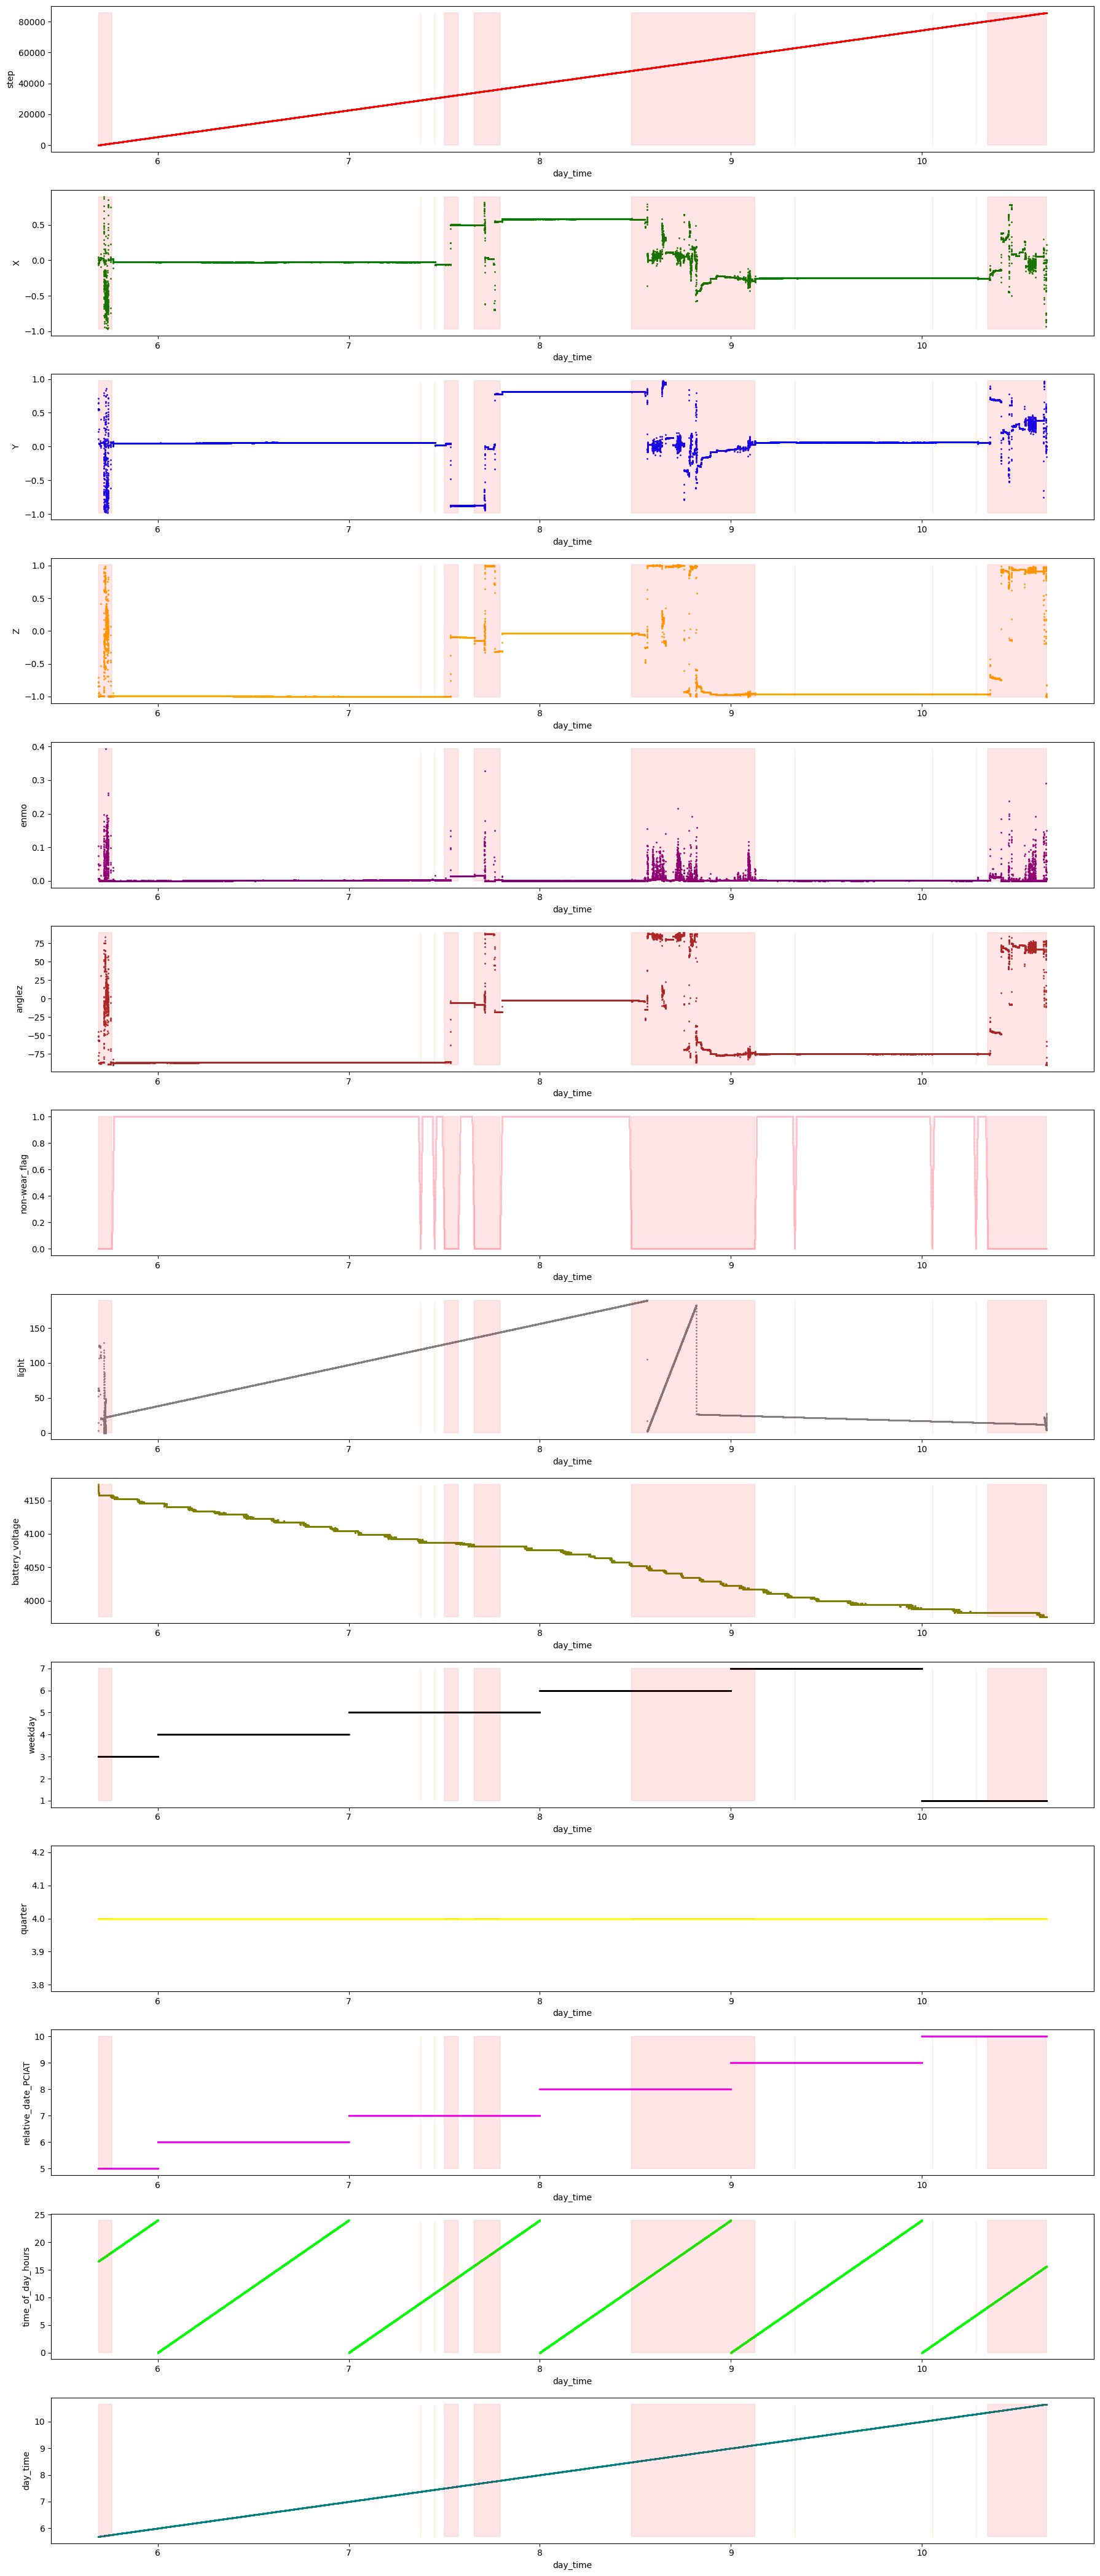

In [33]:
plot_series_data(participant_dfs[8], plot_col=series_train.columns, x_col='day_time')

#### id = 764d8b42
- 8 years old
- sii = 0
- the measurements are very consistent (no big time gaps, in a long time)
- data is collected through 23 days
- this one is very active with high enmo and wide range of anglez
- he always wear the device
- very high exposure to the sunlight
- he also sleeps well
- fully in quarter 3
- this data is very good. we can see why she got the sii = 0

In [34]:
train[train['id'] == participant_ids[9]]

id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
1864  764d8b42                    Spring                8                1   

     CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  \
1864        Fall             60.0          Spring     14.719605   

      Physical-Height  Physical-Weight  ...  PCIAT-PCIAT_18  PCIAT-PCIAT_19  \
1864             45.0             42.4  ...             0.0             0.0   

      PCIAT-PCIAT_20  PCIAT-PCIAT_Total SDS-Season  SDS-SDS_Total_Raw  \
1864             0.0                3.0     Summer               39.0   

      SDS-SDS_Total_T  PreInt_EduHx-Season  \
1864             55.0               Spring   

     PreInt_EduHx-computerinternet_hoursday  sii  
1864                                    0.0  0.0  

[1 rows x 82 columns]

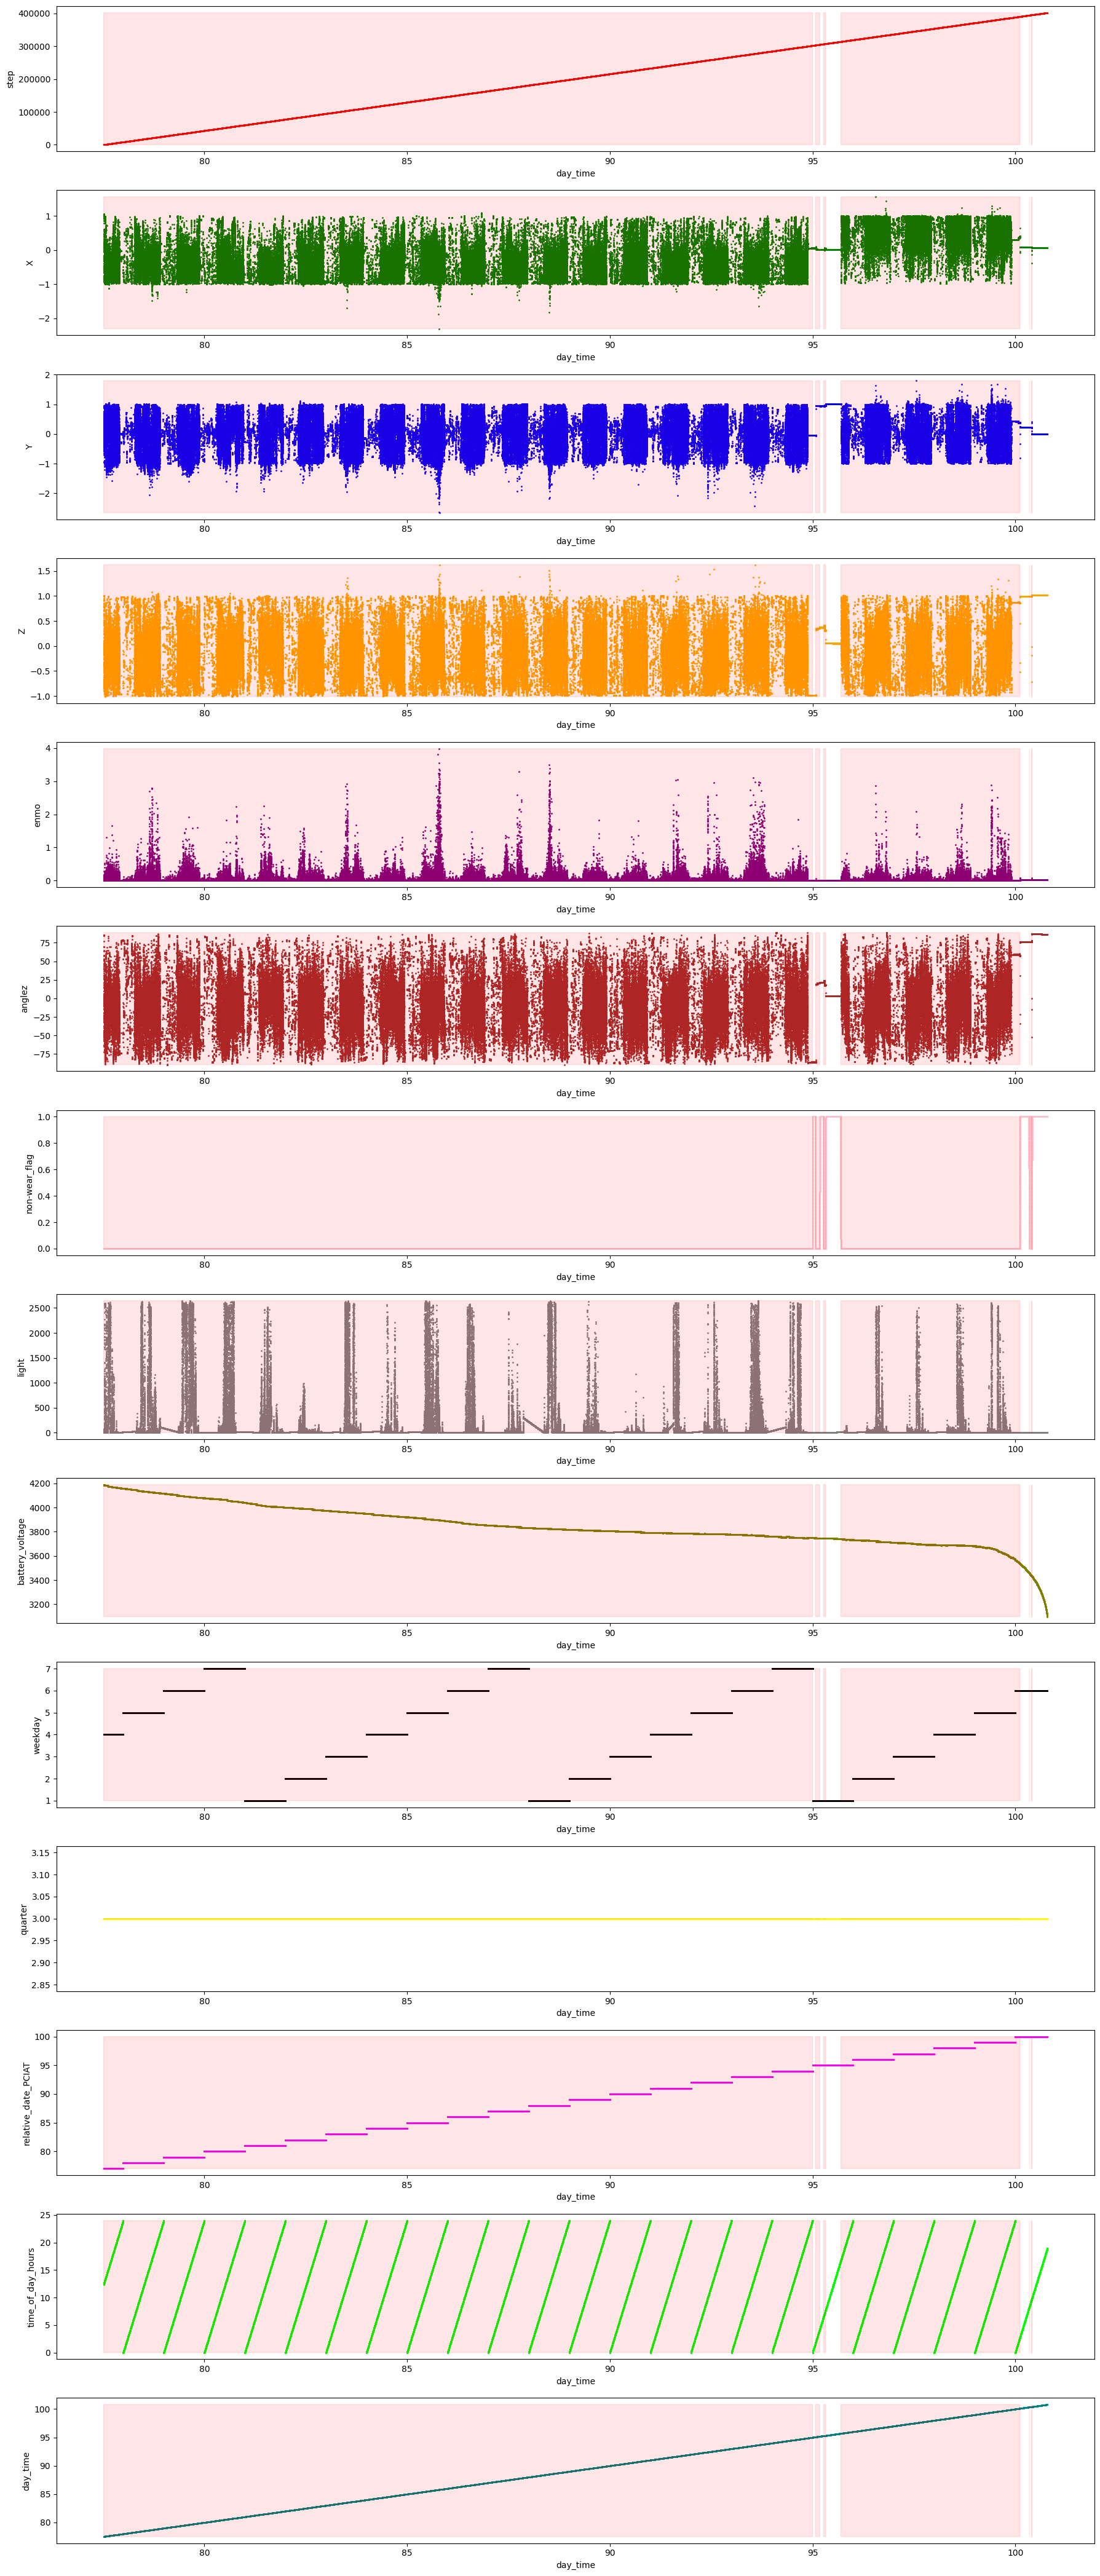

In [35]:
plot_series_data(participant_dfs[9], plot_col=series_train.columns, x_col='day_time')

#### id = 0417c91e
- 6 years old
- sii = 0
- the data is not very consistent (huge gaps after day 35)
- data is collected in about 30 days (excluded the inconsistent period)
- very close to the PCIAT test --> high relevancy?
- high enmo and high anglez --> high relevancy to the age and the sii
- 


In [36]:
train[train['id'] == participant_ids[10]]

id Basic_Demos-Enroll_Season  Basic_Demos-Age  Basic_Demos-Sex  \
68  0417c91e                    Spring                6                1   

   CGAS-Season  CGAS-CGAS_Score Physical-Season  Physical-BMI  \
68      Winter             40.0          Summer     15.484507   

    Physical-Height  Physical-Weight  ...  PCIAT-PCIAT_18  PCIAT-PCIAT_19  \
68             45.5             45.6  ...             0.0             0.0   

    PCIAT-PCIAT_20  PCIAT-PCIAT_Total SDS-Season  SDS-SDS_Total_Raw  \
68             0.0               11.0        NaN                NaN   

    SDS-SDS_Total_T  PreInt_EduHx-Season  \
68              NaN               Summer   

   PreInt_EduHx-computerinternet_hoursday  sii  
68                                    0.0  0.0  

[1 rows x 82 columns]

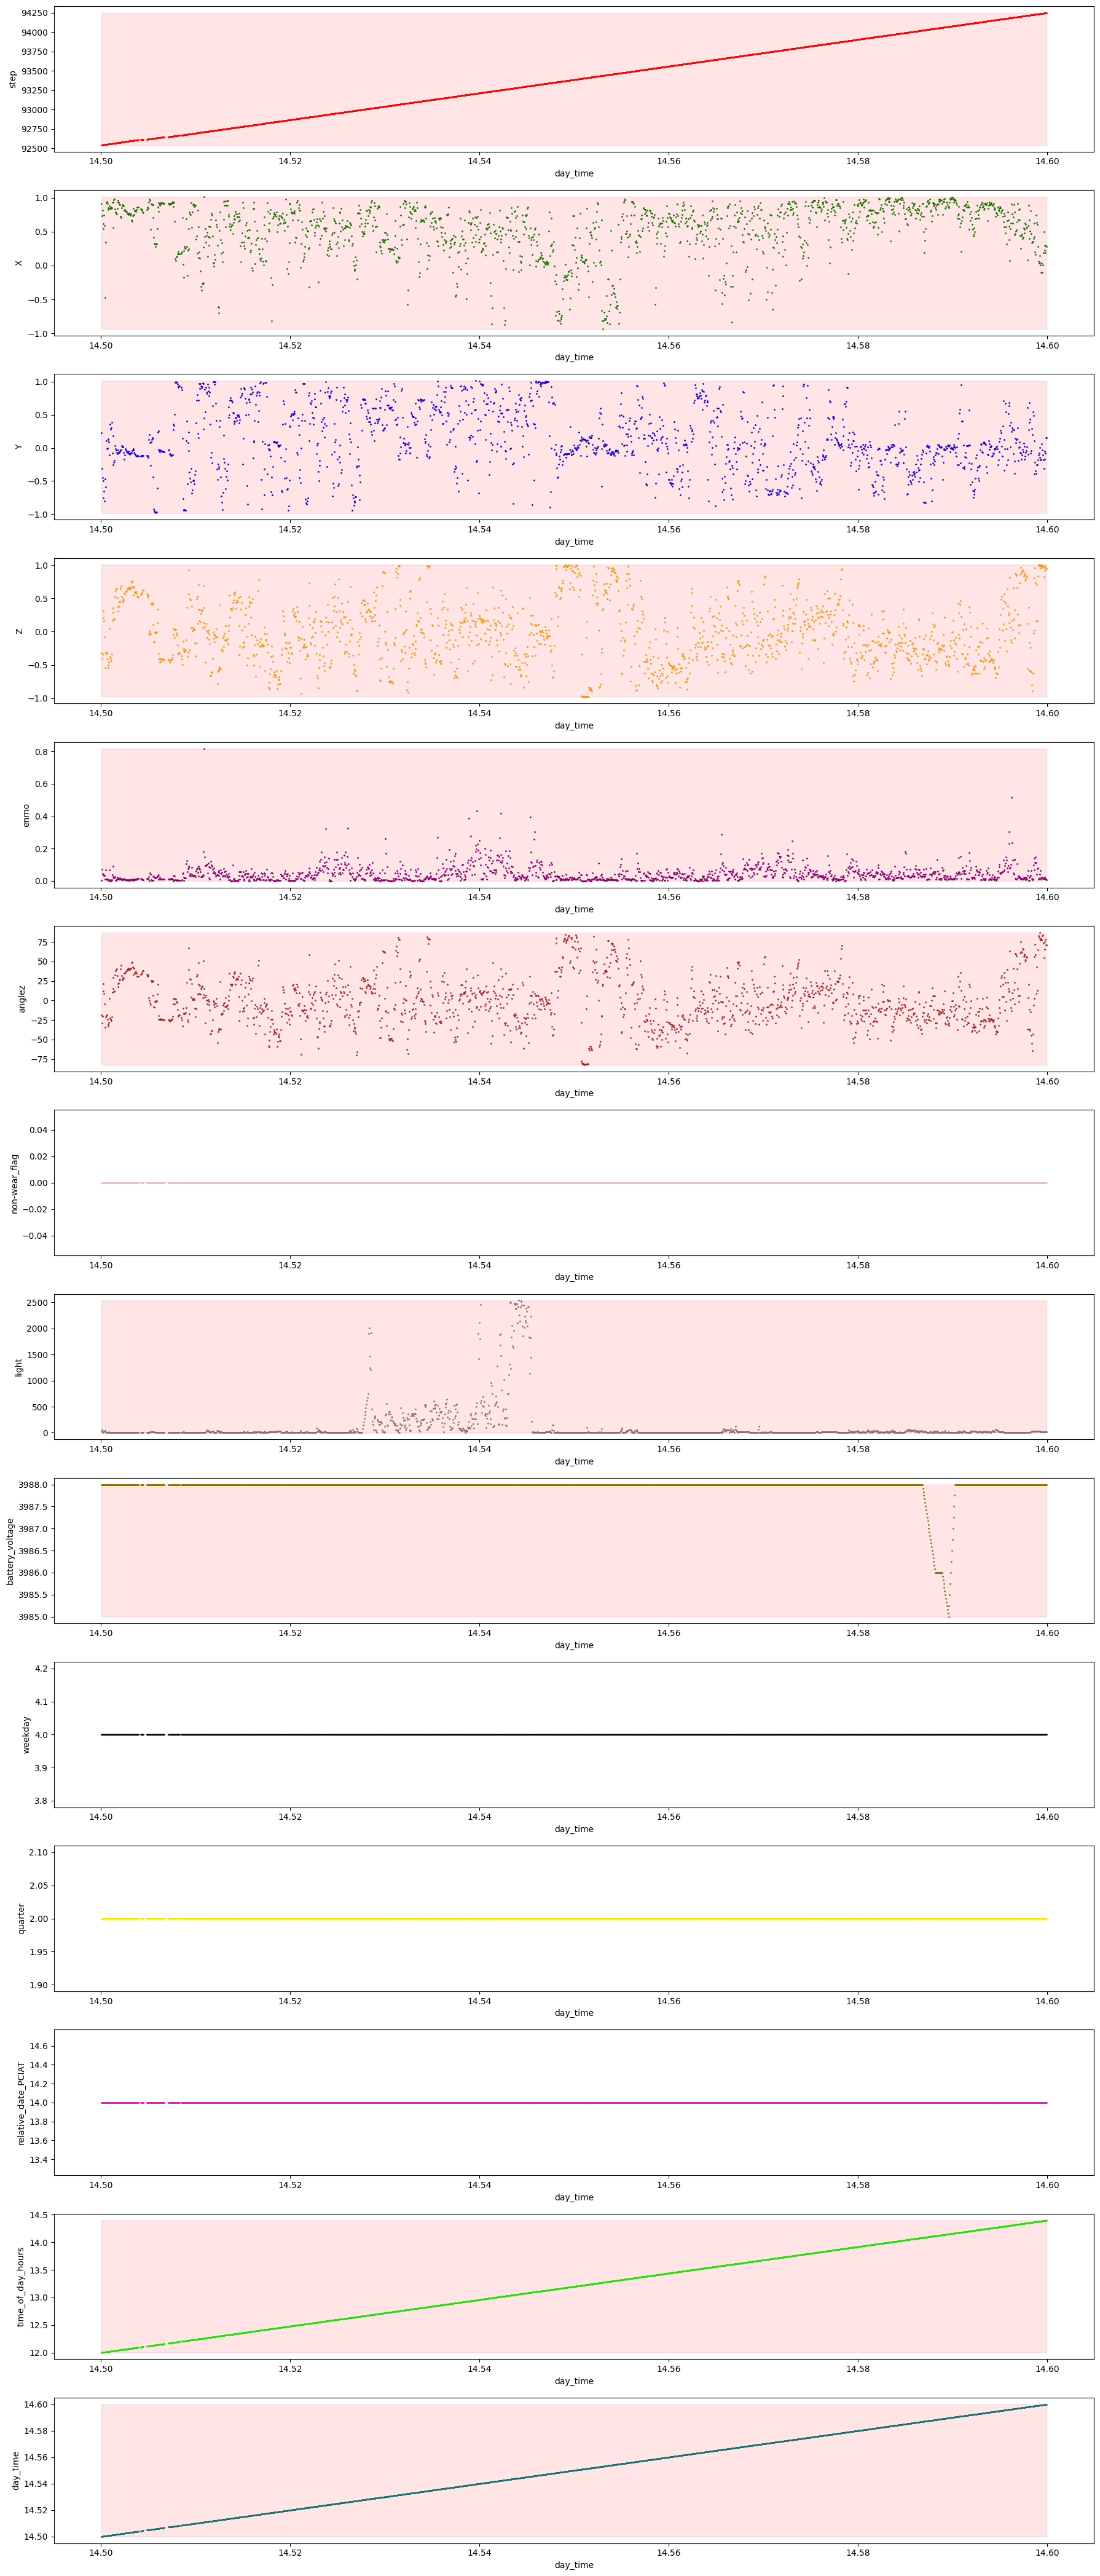

In [37]:
plot_series_data(participant_dfs[10][(participant_dfs[10]['day_time'] > 14.5) & (participant_dfs[10]['day_time'] < 14.6)], plot_col=series_train.columns, x_col='day_time')

In [38]:
# one specific participant's time series data
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
from sklearn.linear_model import LinearRegression


train = pd.read_csv('./train.csv')

participant_ids = ['81d3ab22', '54391716','0a418b57','6b6467f4','579e50bd','6282e693','8f21c613','2bbcfd43','7fa7ccc4','5f78f7b9','764d8b42','0417c91e','045a0a94', '04afb6f9', '04bb1a76', '055156e2', '0668373f', '08660d12', '09331bb8', '0d570d3e', '0ec403df', '10ad8c48', '113f5798', '137baaec', '144a9a79', '1957153d', '1aff6762', '1b2eea8f', '1b329556', '1eea8df2', '35fa2ebf', '5e55e9fd', '7f44236f', '8148c785', '9eb283e4', 'a08ebf6e', 'aaefeff0', 'bc4eaf77', 'c308b134', 'df556fd2']
participant_dfs = []

for participant_id in participant_ids:
    path = f'./series_train.parquet/id={participant_id}/part-0.parquet'
    series_train = pd.read_parquet(path) 

    # Create a continuous time scale in days by transforming the `time_of_day` column (which is in nanoseconds) to hours and then combining it with `relative_date_PCIAT``
    series_train['time_of_day_hours'] = (
        series_train['time_of_day'] / 1e9 / 3600 #nanoseconds to hours
    )
    series_train['day_time'] = series_train['relative_date_PCIAT'] + (
        series_train['time_of_day_hours'] / 24
    )
    series_train['time_periods_in_day'] = series_train['time_of_day_hours'].apply(lambda x: round(x))
    series_train.drop(columns=['time_of_day'], inplace=True)
    participant_dfs.append(series_train)


In [39]:
def plot_series_data(df, plot_col=['non-wear_flag'], x_col='day_time'):
    
    colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'gray', 'olive', 'black', 'yellow', 'magenta', 'lime', 'teal', 'coral', 'lightblue', 'lightgreen', 'lavender', 'tan', 'salmon']
    
    number_of_plots = len(plot_col)
    plt.figure(figsize=(18, 3*number_of_plots))
    for i, y_col in enumerate(plot_col):
        plt.subplot(number_of_plots, 1, i+1)
        plt.scatter(df[x_col], df[y_col], label=y_col, color=colors[i], s=1)
        # plt.title(f'Plot for {y_col}')
        plt.ylabel(f'{y_col}')
        plt.xlabel(f'{x_col}')
        plt.fill_between(df[x_col], df[y_col].min(), df[y_col].max(),
                         where=(df['non-wear_flag'] == 0),
                         color='red', alpha=0.1, label='Non-wear device period')
        
        plt.fill_between(df[x_col], df[y_col].min(), df[y_col].max(),
                         where=((df['time_of_day_hours'] < 7) | (df['time_of_day_hours'] > 22)),
                         color='cyan', alpha=0.13, label='Night time period')


    plt.tight_layout()
    plt.show()

In [40]:
def filter_linear_trends(df, filter_data='enmo', window_size=100, r2_threshold=0.95):
    """
    Filters linear trends from actigraphy df.
    - df: pandas dfFrame with time and enmo columns.
    - filter_data: Column name for ENMO values.
    - window_size: Size of sliding window to check for linearity.
    - r2_threshold: R² value above which the segment is considered linear.
    """
    # Smooth the enmo data using a rolling window
    # df[filter_data] = df[filter_data].rolling(window=100, min_periods=1).mean()
    filtered_df = []
    
    # Slide through the df in windows
    for i in range(0, len(df) - window_size, window_size):
        segment = df.iloc[i:i + window_size]
        x = segment['day_time'].to_numpy().reshape(-1, 1)
        y = segment[filter_data].to_numpy()

        # Fit linear regression
        model = LinearRegression().fit(x, y)        
        # Calculate R² score
        r2 = model.score(x, y)
        
        # Include segment only if it is not linear
        if r2 < r2_threshold:
            filtered_df.append(segment)
    
    # Concatenate the non-linear segments back together
    return pd.concat(filtered_df, ignore_index=True)

     Basic_Demos-Age  Basic_Demos-Sex  sii
236                7                1  2.0
number of steps: 225134


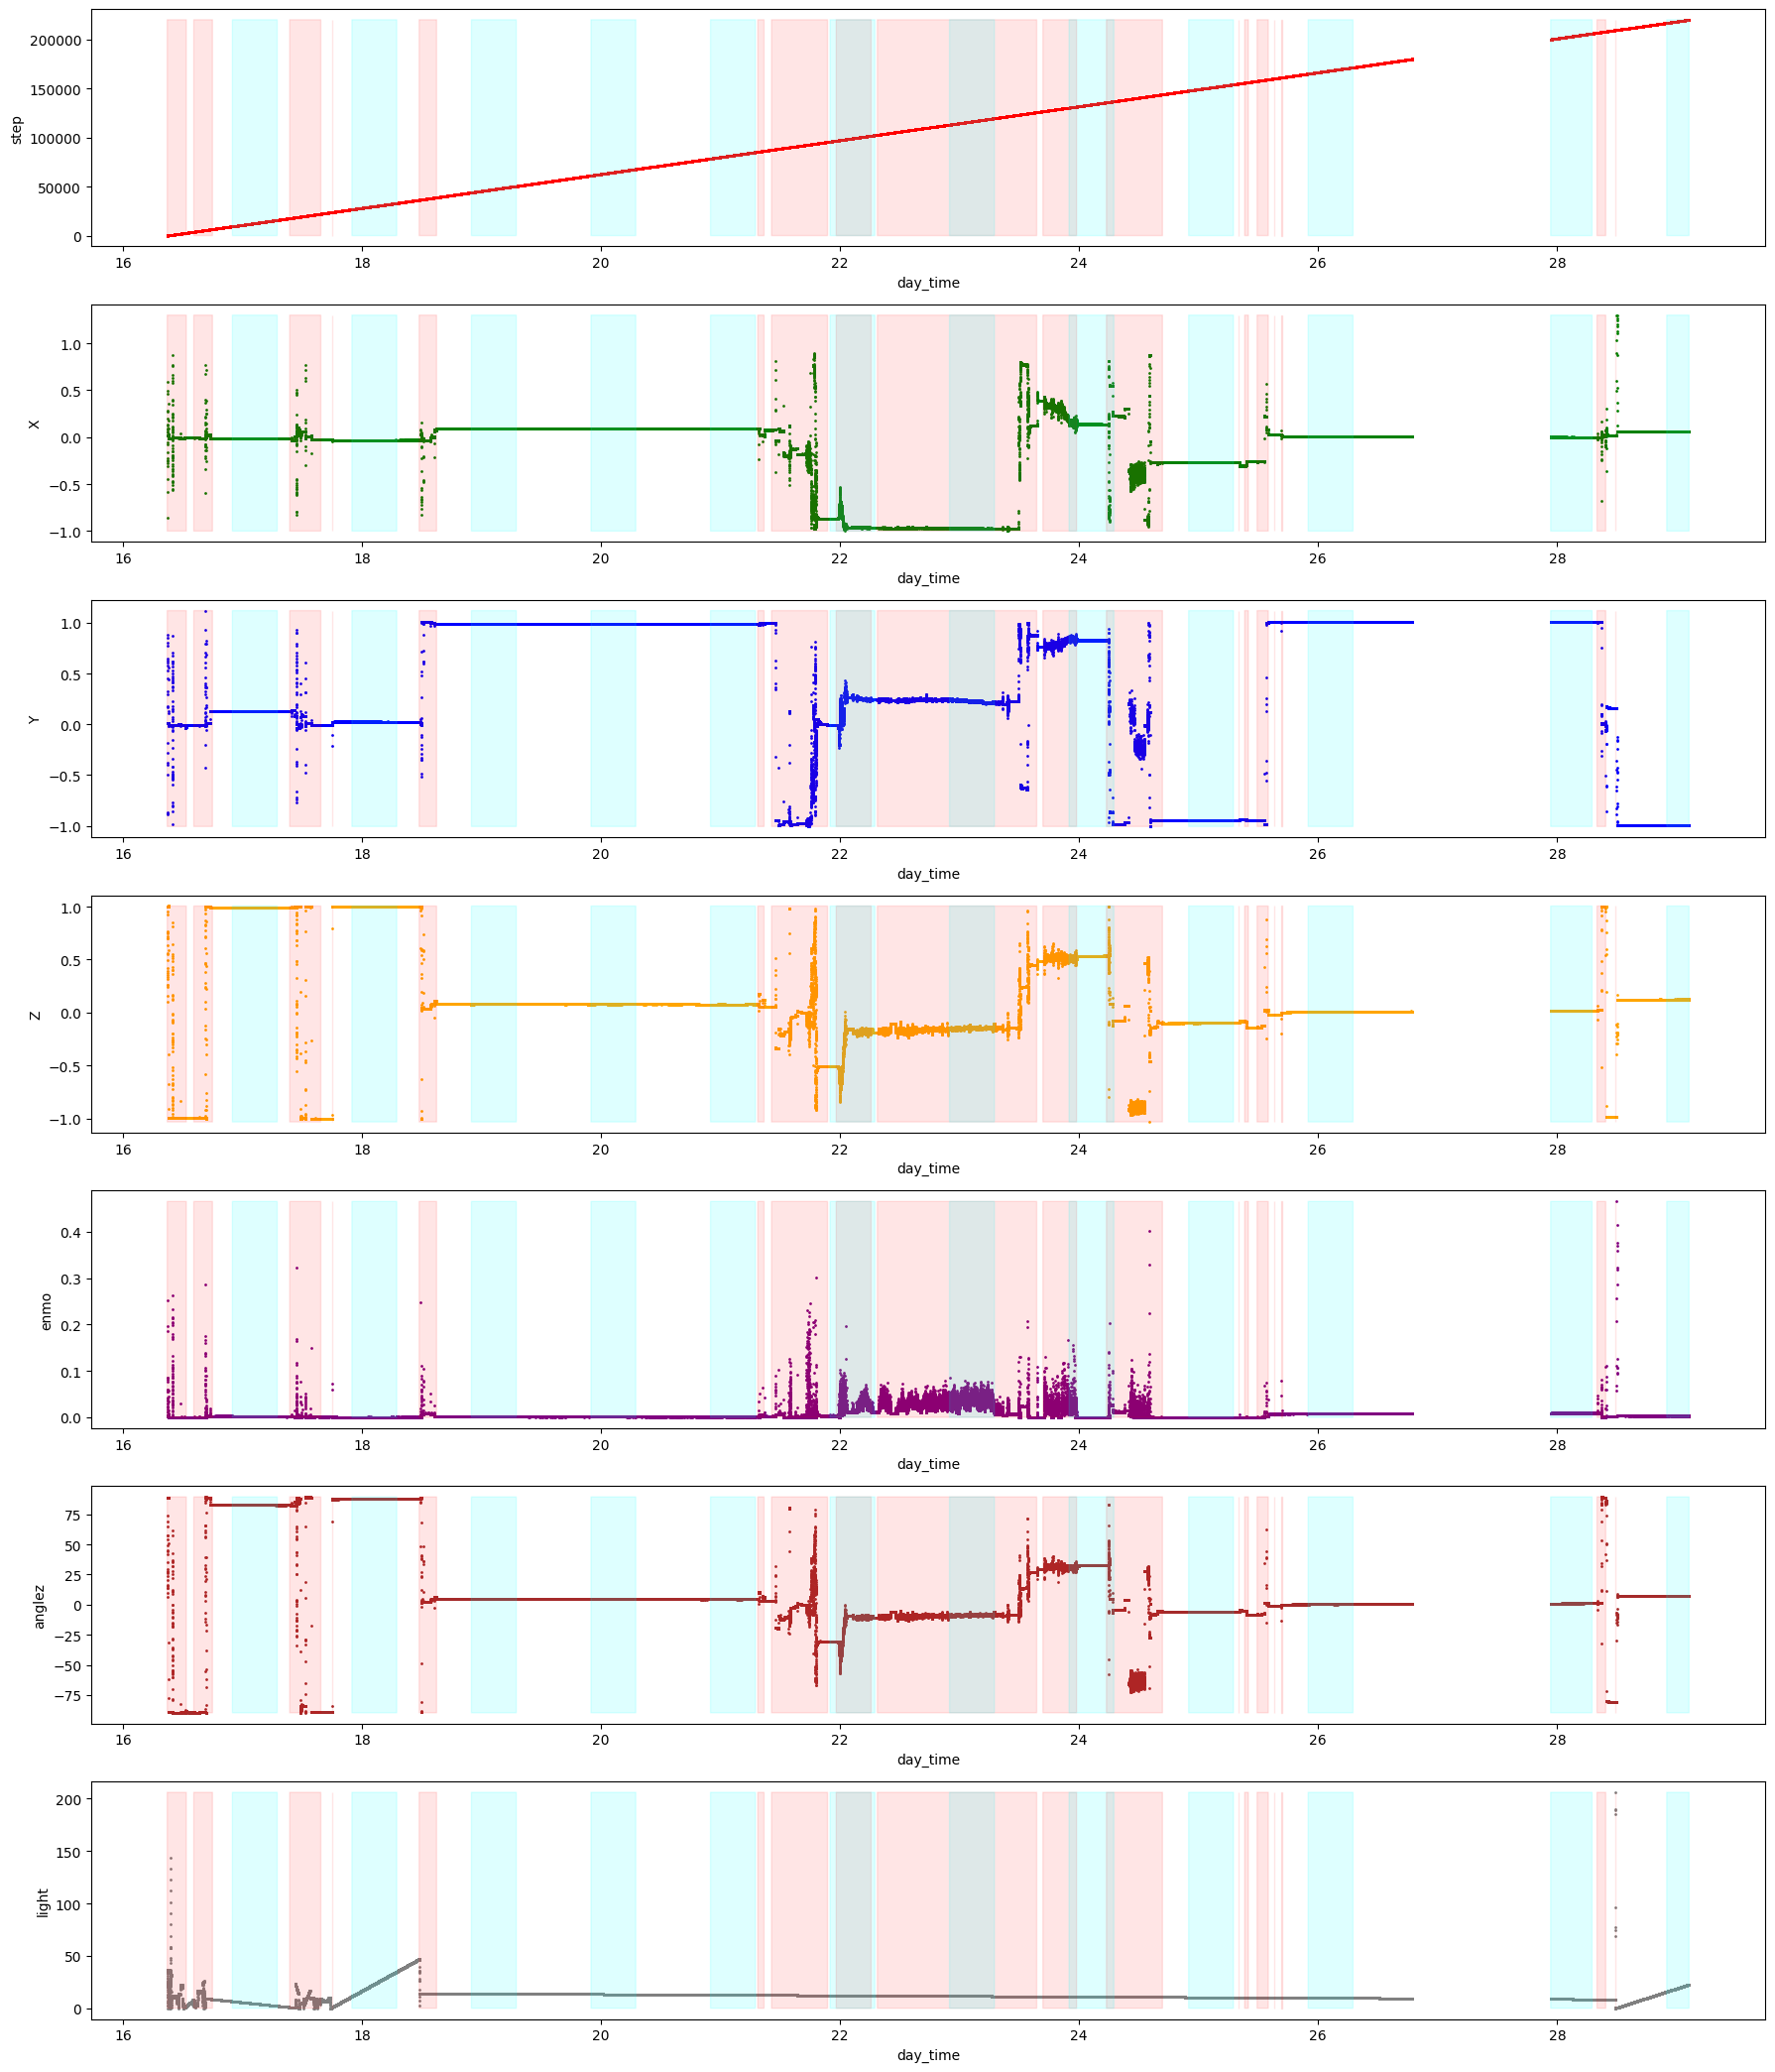

In [41]:
plot_id = 19
print(train[train['id'] == participant_ids[plot_id]][['Basic_Demos-Age','Basic_Demos-Sex','sii']])
print('number of steps:', participant_dfs[plot_id].shape[0])
df_to_be_plotted = participant_dfs[plot_id]
df_to_be_plotted = filter_linear_trends(df_to_be_plotted, filter_data='X', window_size=20000, r2_threshold=0.9)
# df_to_be_plotted = filter_linear_trends(df_to_be_plotted, filter_data='X', window_size=10000, r2_threshold=0.7)
# df_to_be_plotted = filter_linear_trends(df_to_be_plotted, filter_data='X', window_size=5000, r2_threshold=0.6)



plot_series_data(df_to_be_plotted, plot_col=['step','X','Y','Z','enmo','anglez','light'], x_col='day_time')
# plot_series_data(df_to_be_plotted[(df_to_be_plotted['day_time']  > 19 ) & (df_to_be_plotted['day_time'] < 20)], plot_col=['step','X','Y','Z','enmo','anglez'], x_col='day_time')


In [42]:
def take_out_sleep_data(df):
    average_enmo_each_hour = df.groupby('time_periods_in_day')['enmo'].mean()
    average_enmo_each_hour = average_enmo_each_hour.reset_index()
    average_enmo_each_hour['enmo'] = average_enmo_each_hour['enmo'].rolling(window=3, min_periods=1).mean()
    print(average_enmo_each_hour)
    plt.figure(figsize=(10, 6))
    plt.plot(average_enmo_each_hour['time_periods_in_day'], average_enmo_each_hour['enmo'], marker='o')
    plt.xlabel('Time of Day (Hours)')
    plt.ylabel('ENMO rate')
    plt.title('Average ENMO for Each Hour of the Day')
    plt.grid(True)
    plt.show()


    time_periods_in_day      enmo
0                     0  0.003408
1                     1  0.003804
2                     2  0.004515
3                     3  0.005429
4                     4  0.006009
5                     5  0.005731
6                     6  0.005600
7                     7  0.006971
8                     8  0.017300
9                     9  0.027541
10                   10  0.045763
11                   11  0.057935
12                   12  0.072233
13                   13  0.075551
14                   14  0.076911
15                   15  0.082287
16                   16  0.087434
17                   17  0.091362
18                   18  0.085476
19                   19  0.085738
20                   20  0.079304
21                   21  0.066894
22                   22  0.043139
23                   23  0.022403
24                   24  0.010438


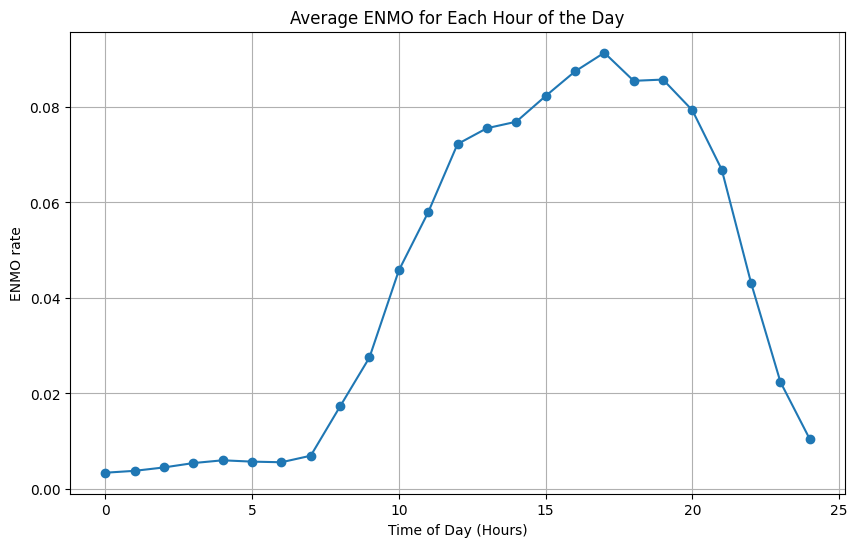

In [43]:
take_out_sleep_data(participant_dfs[10])

# Feature engineering implementation and testing

In [44]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os

import os
train = pd.read_csv('./train.csv')


In [45]:
def filter_actigraphy_data(df):
    # Filter out non-wear device periods
    df = df[df['non-wear_flag'] == 0]
    # Filter out night time periods
    df = df[(df['time_of_day_hours'] >= 7) & (df['time_of_day_hours'] <= 22)]
    if df.shape[0] == 0:
        return None
    
    return df

In [46]:
#Load actigraphy data of all participants to dataframes

acti_dfs = []
list_all_ids = [path.split('=')[1] for path in os.listdir('./series_train.parquet')]

for id in list_all_ids:
    serie_df = pd.read_parquet(f'./series_train.parquet/id={id}/part-0.parquet')
    # Create a continuous time scale in days by transforming the `time_of_day` column (which is in nanoseconds) to hours and then combining it with `relative_date_PCIAT``
    serie_df['time_of_day_hours'] = (
        serie_df['time_of_day'] / 1e9 / 3600 #nanoseconds to hours
    )
    serie_df['day_time'] = serie_df['relative_date_PCIAT'] + (
        serie_df['time_of_day_hours'] / 24
    )
    serie_df.drop(columns=['time_of_day'], inplace=True)
    # serie_df = filter_actigraphy_data(serie_df)
    acti_dfs.append(serie_df)



In [47]:
count = 0
for df in acti_dfs:
    if df.shape[0] == 0:
        count += 1
print(count)

0


In [48]:
# create all of the dataframe, lists of data that will be included in the final aggregated dataframe

stats_df = pd.DataFrame()
stats_df['id'] = list_all_ids

bed_time_stats = []
wake_time_stats = []
avg_sleep_hour_stats = []
PCIAT_relevancy = []
low_enmo_percentage = []
mod_enmo_percentage = []
high_enmo_percentage = []
non_active_time_percentage = []
total_step_recorded = []
low_light_percentage_percentage = []
mod_light_percentage_percentage = []
high_light_percentage_percentage = []
quarter = []



In [49]:
# calculate PCIAT relevancy

PCIAT_relevancy = []
for df in acti_dfs:
    PCIAT_relevancy.append(1 / df['day_time'].mean() + 1)

stats_df['PCIAT_relevancy'] = PCIAT_relevancy

KeyboardInterrupt: 

In [8]:
# calculate low_enmo_percentage
low_enmo_percentage = []
for df in acti_dfs:
    low_enmo_percentage.append((df['enmo'] < 0.1).sum() / len(df) * 100)

stats_df['low_enmo_percentage'] = low_enmo_percentage

In [9]:
# calculate mod_enmo_percentage
mod_enmo_percentage = []
for df in acti_dfs:
    mod_enmo_percentage.append(((df['enmo'] >= 0.1) & (df['enmo'] < 0.3)).sum() / len(df) * 100)

stats_df['mod_enmo_percentage'] = mod_enmo_percentage

In [10]:
# calculate high_enmo_percentage
high_enmo_percentage = []
for df in acti_dfs:
    high_enmo_percentage.append((df['enmo'] >= 0.3).sum() / len(df) * 100)

stats_df['high_enmo_percentage'] = high_enmo_percentage

In [11]:
# calculate non_active_time_percentage
non_active_time_percentage = []
for df in acti_dfs:
    non_active_time_percentage.append((df['enmo'] < 0.01).sum() / len(df) * 100)

stats_df['non_active_time_percentage'] = non_active_time_percentage

In [12]:
# caculate total_step_recorded
total_step_recorded = []
for df in acti_dfs:
    total_step_recorded.append(len(df))

stats_df['total_step_recorded'] = total_step_recorded

In [13]:
# calculate low_light_percentage_percentage
low_light_percentage_percentage = []
for df in acti_dfs:
    low_light_percentage_percentage.append((df['light'] <= 30).sum() / len(df) * 100)

stats_df['low_light_percentage_percentage'] = low_light_percentage_percentage


In [14]:
# calculate mod_light_percentage_percentage
mod_light_percentage_percentage = []
for df in acti_dfs:
    mod_light_percentage_percentage.append(((df['light'] > 30) & (df['light'] <= 100)).sum() / len(df) * 100)

stats_df['mod_light_percentage_percentage'] = mod_light_percentage_percentage

In [15]:
# calculate high_light_percentage_percentage
high_light_percentage_percentage = []
for df in acti_dfs:
    high_light_percentage_percentage.append((df['light'] > 100).sum() / len(df) * 100)

stats_df['high_light_percentage_percentage'] = high_light_percentage_percentage

In [16]:
# calculate quarter
quarter = []
for df in acti_dfs:
    quarter.append(df['quarter'].mode()[0])

stats_df['quarter'] = quarter

In [17]:
# attach the sii
sii = []
for id in list_all_ids:
    sii.append(train[train['id'] == id]['sii'].values[0])

stats_df['sii'] = sii

In [18]:
# calculate the non-wear_percentage
non_wear_percentage = []
for df in acti_dfs:
    non_wear_percentage.append((df['non-wear_flag'] == 1).sum() / len(df) * 100)

stats_df['non_wear_percentage'] = non_wear_percentage

In [19]:
# stats_df
stats_df.to_csv('stats_actigraphy.csv', index=False)


In [21]:
stats_df[stats_df['non_wear_percentage'] > 0]
stats_df

id  PCIAT_relevancy  low_enmo_percentage  mod_enmo_percentage  \
1    cefdb7fe        25.416291            93.877021             5.795330   
2    58391429        36.800318            99.664002             0.281343   
4    19455336        20.431916            96.550005             2.648213   
5    ca33a5e7        71.051890            99.624888             0.302026   
9    9d6b1410         8.507263            87.530681             7.934304   
..        ...              ...                  ...                  ...   
990  05e94f88        55.897541            99.903515             0.090425   
991  43a7386d        34.014207            98.487528             1.025605   
993  1b329556       104.157263            88.267606             9.208039   
994  62b873a2        74.172888            91.703742             6.018961   
995  57de6095        13.599277            91.590705             5.863145   

     high_enmo_percentage  non_active_time_percentage  total_step_recorded  \
1                0.327649                   55.096864               412332   
2                0.054655                   86.580364               384228   
4                0.801782                   52.909906               377160   
5                0.073086                   97.426041               526776   
9                4.535016                   46.992206               278676   
..                    ...                         ...                  ...   
990              0.006059                   99.463974               429084   
991              0.486868                   93.628047               424140   
993              2.524355                   50.428397               401964   
994              2.277297                   59.809396               401880   
995              2.546150                   62.291225               418632   

     low_light_percentage_percentage  mod_light_percentage_percentage  \
1                          82.587818                         8.901080   
2                          97.665709                         1.949103   
4                          98.108760                         1.152826   
5                          77.677419                        15.601128   
9                          77.899424                         9.314760   
..                               ...                              ...   
990                        94.772585                         5.206440   
991                        97.004763                         1.868251   
993                        83.513449                        10.863659   
994                        88.861849                         8.412213   
995                        95.408617                         4.275115   

     high_light_percentage_percentage  quarter  sii  non_wear_percentage  
1                            8.511103        2  1.0            20.697399  
2                            0.385188        1  2.0            59.091737  
4                            0.738413        1  1.0            64.009174  
5                            6.721453        1  2.0            75.056760  
9                           12.785816        3  0.0            12.598860  
..                                ...      ...  ...                  ...  
990                          0.020975        4  0.0            96.615814  
991                          1.126986        2  1.0            73.457821  
993                          5.622892        3  2.0             0.269178  
994                          2.725938        1  1.0            29.698169  
995                          0.316268        4  0.0            32.488200  

[648 rows x 13 columns]